In [1]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


Loaded chess data in /src/dataloading.py to assemble combined.pgn

# Chess Prediction and Recommendation


#### A Capstone Project by Eduardo Daroza - Galvanize Data Science Immersive

*using CRISP - DM (Cross Industry Standard Process for Data Mining)


1. Business Understanding
---

This initial phase focuses on understanding the project objectives and requirements from a business perspective, and then converting this knowledge into a data mining problem definition, and a preliminary plan designed to achieve the objectives. A decision model, especially one built using the Decision Model and Notation standard can be used.


In chess, prediction of your opponents opening choice prior to the game provides a competitive advantage especially if a player has time to prepare some counter strategies.  Statistically studies have shown that playing white provides a small but measurable advantage in practive since white has the first move and may general has more influence in the opening battle.  

This capstone project will use chess data freely available on the web to aid in opening prediction to aid in the pre-game preparation for a chess player.  The goal will be train an ensemble model to first predict likely opening White moves based a data set of two million games and then to recommend those openings moves which should provide a better likelihood probability of success based on your opponents prior history and that of the likelihood of success of the opening in the dataset.  I will be breaking up the problem into two parts. 

i: First predict the three most likely moves to be made by the opponent.

ii: Second based on the data which responses provide the likelihood of success and to estimate the probability of success for those responses.

The user interface will be available on the web using AWS and flask and a NoSQL db such as mongodb or Dynamodb to store the games for retrieval.

If time allows, I will explore chess style based on openings to try to provide categories of players and provide an interface for the user to practice the opening recommendations using stockfish open source engine.


Challenges: 
Scope of predictions: By its nature and part of its allure chess is somewhat unpredictable due to the variety of possible games.  Players sometimes will play unexpected moves to surprise their opponent even on the first move as Bobby Fischer did in game 8 of the 1972 World Chess Championship where he play the english 1.c4 and went on to win that game and the subsequent match.  After White's first move there 20 possible positions.  Black has 20 moves in response making 400 possible positions.  The average branching factor (number of options a player has given any position)is 20 so that after moves after 5 moves (10 ply) the 
number of possible positions is 4,897,256.  Openings are named for more common positions.  There are over 3600 named openings.  Due to a large target scope and to improve the prediction accuracy I first started by using the ECO coding A00-E99(500) codes.  Even this proved difficult in the modeling so reduced the targets into subgroups of like openings (67).  Most openings end at around move 10. which is 40 X 10^6 positions. (citation: https://www.chess.com/chessopedia/view/mathematics-and-chess).  Accuracy will vary based on number of games a player has, how much variance their is in a players opening repetoire (typical openings) and if their a specialist or generalist (this could be modeled as a player attribute) when it comes to opening the chess game.

2. Data Understanding
---
The data understanding phase starts with an initial data collection and proceeds with activities in order to get familiar with the data, to identify data quality problems, to discover first insights into the data, or to detect interesting subsets to form hypotheses for hidden information.


The web has several chess datasets consisting of millions of historical games.  Chess games are stored in a PGN (portable game notation) file format which is ascii readable and provides the game as well as metadata including the players, ratings, date, and result. 

My first dataset was obtained from http://www.top-5000.nl/pgn.htm as the 2.2 millionbase consisting of over 2 million games.  After some initial data exploration I found some of my own games, however more than 40% of the meta data was incomplete include opening information.  Attempts to scrape the missing data where resource intensive and error prone so I was able to find an alternative data set from KingBase of 1.9 million games which had much better data quality.

3. Data Preparation
---
The data preparation phase covers all activities to construct the final dataset (data that will be fed into the modeling tool(s)) from the initial raw data. Data preparation tasks are likely to be performed multiple times, and not in any prescribed order. Tasks include table, record, and attribute selection as well as transformation and cleaning of data for modeling tools.

I used pandas for much of my initial EDA with a shard of 40,000 games and built my Minimal Viable product.  Below I have included some of the observations I made during the data exploration phase and the subsequent data cleaning and feature engineering used prior to the modeling phase. There is a seperate dataloading.py in my github repo which has some code used to combine the seperate pgns and some webscraping functions.



In [2]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')
from __future__ import unicode_literals

game={}
games = []

pgn_file="combined.pgn"

with open(pgn_file,'r') as datafile:
    for line in datafile:
        line = line.decode('latin-1').encode("utf-8")       
        if line.startswith('['):
            tag,value=line[1:-1].split(' ',1)
            game[str(tag).lower()]=value.replace("]","").strip('"').encode('ascii', 'ignore')
        elif line.startswith('1.'):
            #only read first line: could add more readlines until a space
            game['moves']=line.encode('ascii', 'ignore')
            games.append(game)
            game = {}

In [3]:
df = pd.DataFrame(games) 

In [4]:
df.head(1)

,black,blackelo,date,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo
0,"Kosteniuk, Alexandra""\r","2554""\r","2016.02.29""\r","A05""\r","IMSA Blitz w 2016""\r","2016.02.28""\r",NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,"0-1""\r","15.5""\r",NaN,"Huai'an CHN""\r","Harika, Dronavalli""\r","2511""\r"


Interestingly, the first game in the dataset is from Alexandra Kosteniuk, former women's world champion and model.  I had an interesting game with her ten years ago in a Simul.  For the record I got a decent opening as Black, but she destroyed me in the middle game with a powerful kingside attack and I resigned at move 36.  

I can remove two column which don't have any predictive power.  FEN(Forsyth Edwards Notation) tracks a board position and is largely blank and setup which is used to capture games in progress.  We only care about games that started from move one.

In [5]:
df[df['fen'].isnull()==False]

,black,blackelo,date,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo
1114192,"Jurkovic, Hrvoje""\r","2426""\r","2006.??.??""\r","B22""\r","2. Bundesliga Mitte 2005/06 rounds 3-5""\r","2006.02.03""\r",rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,1...c5 2.c3 Nf6 3.e5 Nd5 4.d4 cxd4 5.Nf3 Nc6 6...,"0-1""\r","6.3""\r","1""\r","AUT""\r","Jeric, Simon""\r","2328""\r"


In [36]:
#garbage = test.pop('blackteam')
#garbage = test.pop('blacktitle')
#garbage = test.pop('whiteteam')
#garbage = test.pop('whitetitle')
#garbage = df.pop('eventdate')
#garbage = df.pop('eventtype')
##garbage = df.pop('site')
#garbage = test.pop('variation')
#garbage = df.pop('eco') # most precise drop for now in first dumb model
#garbage = test.pop('blackfideid')
#garbage = test.pop('whitefideid')
#garbage = df.pop('event')
garbage = df.pop('fen')
garbage = df.pop('setup')
#garbage = df.pop('round') # may have alot of variance, but keep to see if first round and last round have influence...combine with event
#garbage = data_df.pop('opening') # second most precise drop for now in first dumb model

Ran into some encoding/unicode issues preventing loading so added decode('latin-l') due to some special character in the file.  And '"\r' was being appended during the dataloading so addressed this in data cleaning.

In [9]:
df.head(1)

,black,blackelo,date,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo
0,"Kosteniuk, Alexandra",2554,2016.02.29,A05,IMSA Blitz w 2016,2016.02.28,NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,0-1,15.5,NaN,Huai'an CHN,"Harika, Dronavalli",2511


In [8]:
df.white = df.white.map(lambda x: x.rstrip('"\r'))
df.black = df.black.map(lambda x: x.rstrip('"\r'))
df.blackelo = df.blackelo.map(lambda x: x.rstrip('"\r'))
df.date = df.date.map(lambda x: x.rstrip('"\r'))
df.eco = df.eco.map(lambda x: x.rstrip('"\r'))
df.result = df.result.map(lambda x: x.rstrip('"\r'))
df.whiteelo = df.whiteelo.map(lambda x: x.rstrip('"\r'))

df['round'] = df['round'].map(lambda x: x.rstrip('"\r'))
df.event = df.event.map(lambda x: x.rstrip('"\r'))
df.eventdate = df.eventdate.astype(str).map(lambda x: x.rstrip('"\r'))
df.site = df.site.map(lambda x: x.rstrip('"\r'))
df.moves = df.moves.map(lambda x: x.rstrip('"\r'))

Change result of game to numerical value.  Choose a balanced value centered at zero to help with calculation.  Updated date field to be a date type and grabbing first moves for both colors to be used as another target value.  Due to opening transposition many openings can result from many first moves.

In [10]:
d = {
'0-1':-1.0,
'1-0':1.0,
'1/2-1/2':0.0
}
#update feature
df['result'] = df['result'].map(d)


In [11]:
df.date = map(lambda x: str(x).replace(".",""),df.date)
df.date = pd.to_datetime(df.date, format='%Y%m%d', errors='ignore')
df['white_first_move'] = df.moves.apply(lambda x: x.split(" ")).apply(lambda x: x[0])
df['black_first_move'] = df.moves.apply(lambda x: x.split(" ")).apply(lambda x: x[1])

In [12]:
import pandas as pd
import datetime as DT
import io
import numpy as np
import math
from matplotlib import pyplot as plt
now = pd.Timestamp(DT.datetime.now())
#df['age'] = (now - df['date']).astype('timedelta64[D]')

#inpute some dates for rows with "??"

In [13]:
df.date = map(lambda x: str(x).replace("?","1"),df.date)
str(df.date).find("?") #validate no more missing
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d', errors='coerce'))

df['age'] = (now - df['date']).astype('timedelta64[D]')
garbage = df.pop('date')


In [14]:
min(df.age) # most recent game is 261 days old

261.0

In [15]:
max(df.age) # oldest recent game is  9816 days old

9816.0

In [16]:
df.age.mean() #average is 10 years old

3894.717754091474

In [17]:
#drop some incomplete data
df.white_first_move.unique()
df[df.white_first_move == '1...c5']


,black,blackelo,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo,white_first_move,black_first_move,age
1114192,"Jurkovic, Hrvoje",2426,B22,2. Bundesliga Mitte 2005/06 rounds 3-5,2006.02.03,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,1...c5 2.c3 Nf6 3.e5 Nd5 4.d4 cxd4 5.Nf3 Nc6 6...,-1.0,6.3,"1""\r",AUT,"Jeric, Simon",2328,1...c5,2.c3,3658.0


In [18]:
df = df.drop(df.index[1114192])

In [19]:
df.head(1)

,black,blackelo,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo,white_first_move,black_first_move,age
0,"Kosteniuk, Alexandra",2554,A05,IMSA Blitz w 2016,2016.02.28,NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,15.5,NaN,Huai'an CHN,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0


In [20]:
# calculate the ELO winning probability estimate based on ratings 
# with a 32 point rating adjustment given to white as this has been observed empirically
# CITATION NEEDED
# whites first move advantage is less at beginner level but since this dataset is mainly more experienced players 
#will simplify and adjust all white as 32. 
def win_estimate_df(df,adj=32):
    """input is two ratings ratingA (white), ratingB (black)
    and an optional adjustment factor (adj) which will be added
    to ratingA (white). Usually white has a small advantage which
    has been observed to be about +32 to +50"""
    df[0] = df[0]+adj
    diff = df[1]-df[0]
    ex = diff/400.
    return 1/(1+math.pow(10,ex))

df.whiteelo = df.whiteelo.astype(int)
df.blackelo = df.blackelo.astype(int)

df['estimate_white_win_by_rating'] = df[['whiteelo','blackelo']].apply(win_estimate_df,axis=1)

This is a good point to pickle the dataframe object before I do heavy cleaning and imputing

In [22]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df.pkl", "wb" ) )

i am here.  reload pickled df after crash

In [3]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


In [4]:
import cPickle as pickle
df = pickle.load( open( "../data/df.pkl", "rb" ) )

In [5]:
df.head(1)

,black,blackelo,eco,event,eventdate,fen,moves,result,round,setup,site,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating
0,"Kosteniuk, Alexandra",2554,A05,IMSA Blitz w 2016,2016.02.28,NaN,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,15.5,NaN,Huai'an CHN,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175


In [6]:
garbage = df.pop('fen')
garbage = df.pop('setup')

In [20]:
#dealing with rounds.  code was breaking when trying to convert round to float as this is a huge time sync 
# i decided ultimately to skip round for now as too many rows have missing data and it may be errorneous to assume the average 
#round of 3 for imputing as some tournament last longer.
#df[df['round'].apply(str.isdigit) == False]['round'].apply(float)

In [6]:
test = df[df['round'] != '?']['round']

In [14]:
float(test.head(1)[0])

15.5

In [8]:
df['round'] = map(lambda x: str(x).replace("?","3"),df['round'])
str(df['round']).find("?") #validate no more missing

-1

In [24]:
df['round'] = map(lambda x: str(x).replace(",","."),df['round'])
str(df['round']).find(",") #validate no more missing

987

I wanted to obtain first and last round as another feature
as first and last rounds may correlate to opening selection.  
and might allow me to obtain standings in the tournament another possible correlation
however alot of missing data in round info ~47000 rows

In [59]:
df.groupby(['site','event'])['round'].max()  

site                    event                               
                                                                14.2
's-Hertogenbosch NED    HMC Calder Cup A                           5
                        HMC Calder Cup B                           5
                        HMC Calder Cup Rapid Match                 8
(CL 9-92)               (CL 9-92)                                  ?
(CL11_92)               (CL11_92)                                  ?
01, Oostende op         01, Oostende Open                          ?
02 Antwerp op           02 Open                                    ?
03 Far West op          03 Far West Open                           ?
03, op Oberwart         03, Open                                   ?
04, Dortmund            04                                         ?
04, Illinois Class MX   04, Class MX                               ?
05 Ter Apel             05                                         ?
05, op Oberwart         05, Open          

In [26]:
df[df['round']=='?']['black'].count()

0

So two options would be to impute or remove this data. 

In [ ]:
#this breaks since round is an object that cant be converted
#df['round'].mean()  

In [28]:
df.head(1)

,black,blackelo,eco,event,eventdate,moves,result,round,site,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating
0,"Kosteniuk, Alexandra",2554,A05,IMSA Blitz w 2016,2016.02.28,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,15.5,Huai'an CHN,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175


In [8]:
garbage = df.pop('event')
garbage = df.pop('round')
garbage = df.pop('site')

#explore rating as a function of time and inactivity

Just took a random single sample to see if it may be worth checking out if gaps in activity could be used to infer loss of ratings points. however research was inconclusive.  May be that not all tournament games played are not always recorded and put into database.  probably would add some variance to the model.  So will drop further investigation for now.

In [80]:
testdf = df[['black','blackelo','age']]

In [81]:
testdf2 = df[['white','whiteelo','age']]

In [82]:
testdf.head(1)

,black,blackelo,age
0,"Kosteniuk, Alexandra",2554,261.0


In [83]:
testdf2.head(1)

,white,whiteelo,age
0,"Harika, Dronavalli",2511,261.0


In [84]:
testdf2 = testdf2.rename(columns = {'white':'player','whiteelo':'rating'})

In [85]:
testdf = testdf2.rename(columns = {'black':'player','blackelo':'rating'})

In [86]:
testdf_merged = pd.concat([testdf, testdf2], axis=0)

In [87]:
testdf_merged.head(1)

,player,rating,age
0,"Harika, Dronavalli",2511,261.0


In [92]:
%matplotlib inline

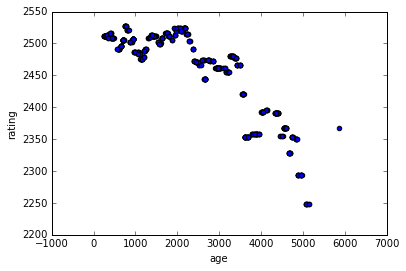

In [94]:
testdf[testdf['player']=='Harika, Dronavalli'].plot('age','rating',kind='scatter')

There is some correlation between age of game and rating by player.  it is possible to model this as some ratings estimator but not really needed for my goal since i have the players rating.

In [100]:
ratings = testdf.drop_duplicates()

In [112]:
ratingsA = ratings[ratings.sort('age')['player']=='Harika, Dronavalli']

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [119]:
ratingsA= ratingsA.sort('age')

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [120]:
ratingsA['gap_events'] = ratingsA['age'] - ratingsA['age'].shift(1) 

In [137]:
ratingsA.head(5)

,player,rating,age,gap_events,ratings_delta
34,"Harika, Dronavalli",2511,262.0,1.0,NaN
933487,"Harika, Dronavalli",2511,263.0,1.0,0.0
303668,"Harika, Dronavalli",2511,264.0,1.0,0.0
456458,"Harika, Dronavalli",2511,268.0,4.0,0.0
456466,"Harika, Dronavalli",2511,269.0,1.0,0.0


In [122]:
ratingsA = ratingsA.drop(ratingsA.index[0])

In [132]:
ratingsA['ratings_delta'] = ratingsA['rating'] - ratingsA['rating'].shift(1) 

plot of ratings change vs date gaps with no apparent trends for sample size of 1.

explore ratings change for a player as a function of inactivity.  it could be useful to model and estimate acual strength after 
prolongued breaks in inactivity such as hving a baby.

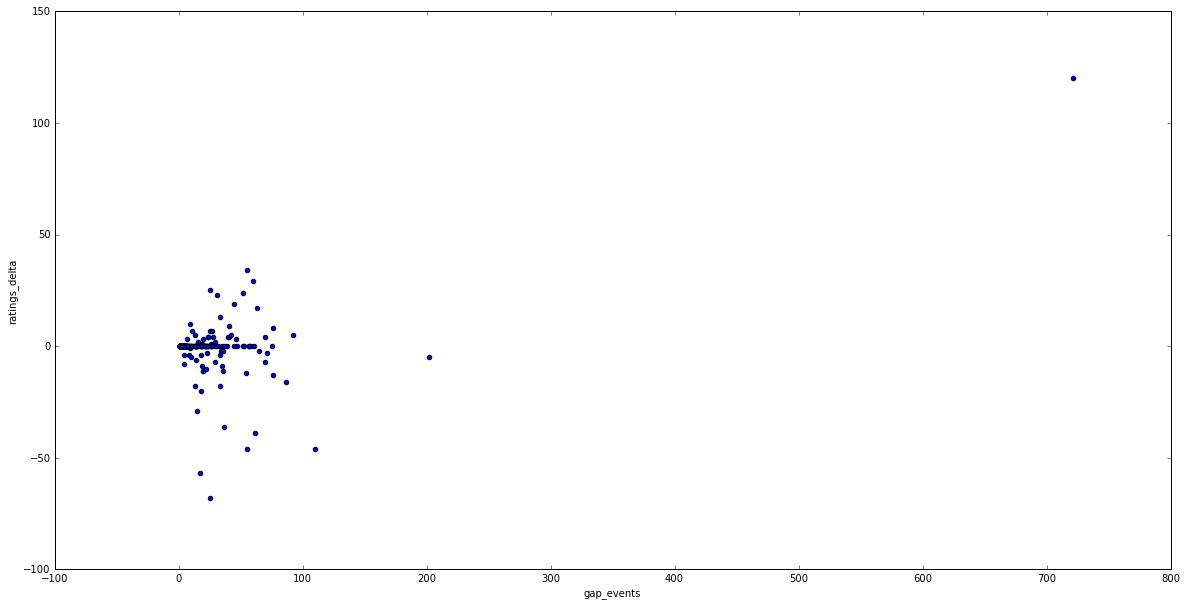

In [136]:
ratingsA.plot('gap_events','ratings_delta',kind='scatter',figsize=(20,10))

In [181]:
df.head(1)

,black,blackelo,eco,eventdate,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating
0,"Kosteniuk, Alexandra",2554,A05,2016.02.28,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175


In [9]:
garbage = df.pop('eventdate')

In [10]:
df.isnull().sum()

black                             0
blackelo                          0
eco                               0
moves                             0
result                          157
white                             0
whiteelo                          0
white_first_move                  0
black_first_move                  0
age                              31
estimate_white_win_by_rating      0
dtype: int64

This next row will drop any rows that still have missing values.

In [12]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [14]:
df['diff'] = df['blackelo']-df['whiteelo']

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff
0,"Aaberg, Anton",72,72,72,72,72,72,72,72,72,72,72
1,"Aabling-Thomsen, Jakob",175,175,175,175,175,175,175,175,175,175,175
2,"Aadeli, Arvin",2,2,2,2,2,2,2,2,2,2,2
3,"Aagaard, Gert",8,8,8,8,8,8,8,8,8,8,8
4,"Aagaard, Jacob",454,454,454,454,454,454,454,454,454,454,454


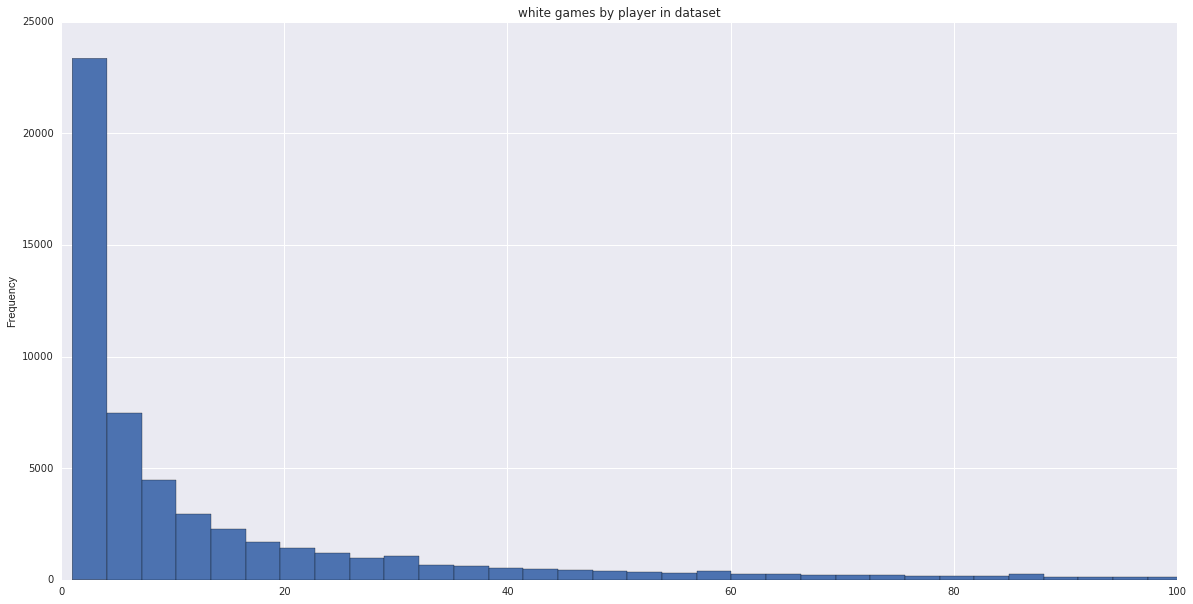

In [33]:
#some EDA:
import seaborn as sns
%matplotlib inline

df.groupby('white').count().sort('black',ascending=False)['black'].plot(kind='hist',bins=570,figsize=(20,10),xlim=(0,100),title='white games by player in dataset')

#how many times in the database by color
df.groupby('white').count().reset_index().head()
df.groupby('black').count().reset_index().head()


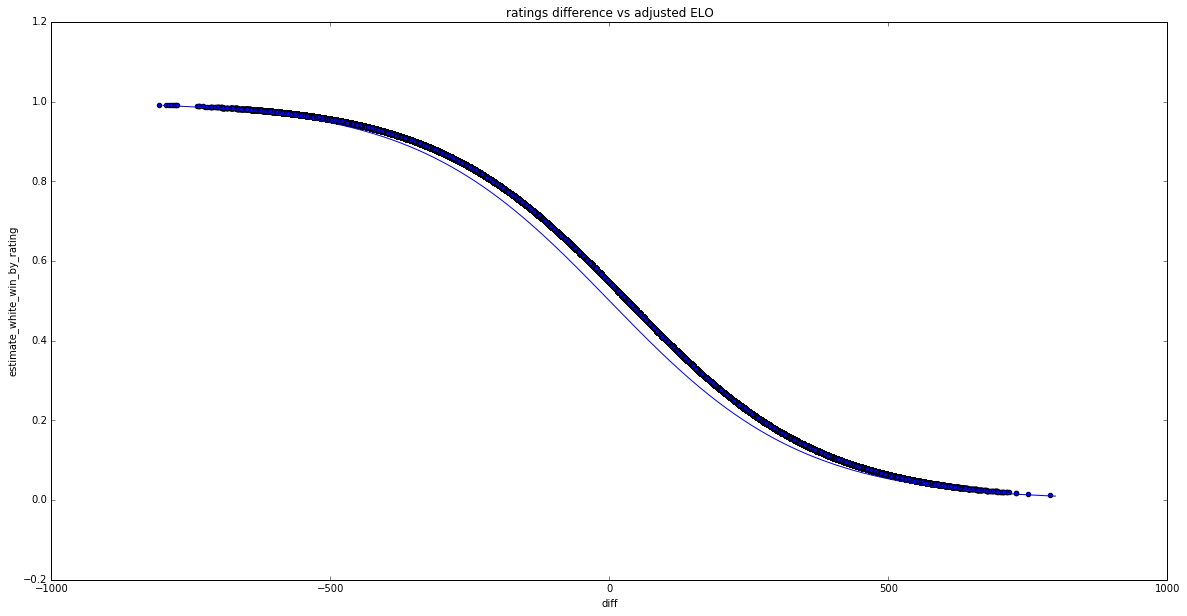

In [22]:
# elo formula vs scatter plot of the estimated results by rating difference:
%matplotlib inline
from math import pow 
df[['diff','estimate_white_win_by_rating']].plot(kind='scatter',x='diff',y='estimate_white_win_by_rating',figsize=(20,10),title="ratings difference vs adjusted ELO")
t = xrange(-800,800,1)
s=[]
for item in t:
    output = 1.0/(1 + pow(10.0,item/400.0))
    s.append(output)
plt.plot(t, s)


standard deviation of ratings difference:165.400705229


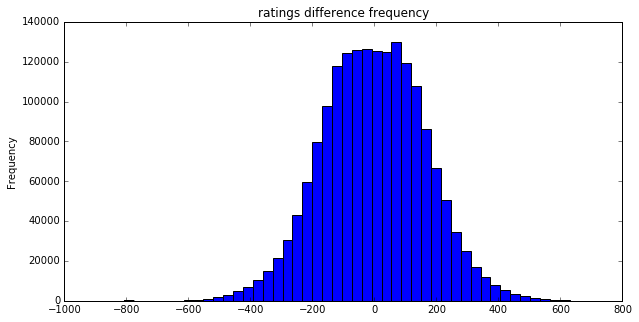

In [23]:

#avg rating difference between players is small
df['diff'].sum()/df['diff'].count()
#pairings end up being a normal distribution based on rating due to use of a swiss pairing system
df['diff'].plot(kind='hist',bins=50,title='ratings difference frequency',figsize=(10,5))
# 2 sigma is +/-330 points so one class above and below
print "standard deviation of ratings difference:{}".format(df['diff'].std())


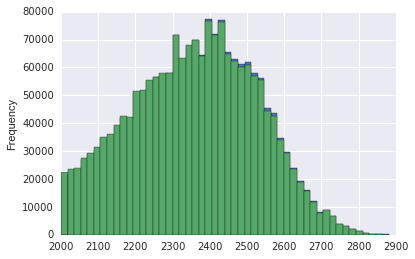

In [41]:

#ratings distribution
df.whiteelo.plot(kind='hist',bins=50)
df.blackelo.plot(kind='hist',bins=50)

#statistically different ratings?
#what are the confidence levels...can i say about similar ratings to normalize opening results?

#add number of games in the database by player...related to activity as well as time since last tournament.
#then use linear regression to predict avg rating drop between tournaments.
#count number of player by opening

#garbage = df.pop('black_first_move')
#garbage = df.pop('diff')


In [42]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43


In [43]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [44]:
df.count()

black                           1861396
blackelo                        1861396
eco                             1861396
moves                           1861396
result                          1861396
white                           1861396
whiteelo                        1861396
white_first_move                1861396
black_first_move                1861396
age                             1861396
estimate_white_win_by_rating    1861396
diff                            1861396
dtype: int64

In [187]:
#garbage = df.pop('moves')

In [ ]:
#additional feature engineering

#considered booleanizing titled/non-titled

In [45]:
df["white_first_move"] = df["white_first_move"].astype('string')
df["black_first_move"] = df["black_first_move"].astype('string')
df["eco"] = df["eco"].astype('string')
df["white"] = df["white"].astype('string')
df['black'] = df['black'].astype('string')

Encode white names ...can no longer use to dummy

In [47]:
catenc = pd.factorize(df['white'])

In [48]:
df['white_enc'] = catenc[0]

count number of games in dataframe for a single user

In [235]:
df[(df.black=='Kosteniuk, Alexandra')|(df.white=='Kosteniuk, Alexandra')].shape[0]

1599

In [236]:
ak_df = df[(df.black=='Kosteniuk, Alexandra')|(df.white=='Kosteniuk, Alexandra')]

In [ ]:
#unique eco codes or variety of openings played

In [242]:
len(ak_df[ak_df.white=='Kosteniuk, Alexandra'].eco.unique())

161

In [ ]:
#unique first moves or variety of first moves played

calculate the number of games played by white with same opening per player:

In [57]:
temp = df.groupby(['white','eco']).size().reset_index().rename(columns={0:'white_opening_count'})

In [178]:
temp2 = df.groupby(['black','eco']).size().reset_index().rename(columns={0:'black_opening_count'})

In [ ]:
866507/1790000.0

In [111]:
df = df.join(temp.set_index(['white','eco']), on=('white','eco'))

In [89]:
testdummy = df.groupby(['white','eco'])['white'].size().reset_index()

In [102]:
testdummy[testdummy['white']=='Harika, Dronavalli'].head()

,white,eco,0
287114,"Harika, Dronavalli",A00,3
287115,"Harika, Dronavalli",A03,1
287116,"Harika, Dronavalli",A04,10
287117,"Harika, Dronavalli",A05,4
287118,"Harika, Dronavalli",A06,6


In [ ]:
verify some of the values

In [105]:
df.loc[(df['white']=='Harika, Dronavalli') & (df['eco'] == 'A05')]

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_Expert,white_level_GM,white_level_IM,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2243,"Derakhshani, Dorsa",2307,A05,1.Nf3 Nf6 2.b3 b6 3.Bb2 Bb7 4.e3 e6 5.d4 d5 6....,1.0,"Harika, Dronavalli",2513,1.Nf3,Nf6,332.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7734,"Padmini, Rout",2444,A05,1.Nf3 Nf6 2.g3 g6 3.b3 Bg7 4.Bb2 d5 5.c4 O-O 6...,0.0,"Harika, Dronavalli",2509,1.Nf3,Nf6,463.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
84954,"Gomes, Mary Ann",2384,A05,1.g3 Nf6 2.Bg2 c5 3.Nf3 Nc6 4.d4 cxd4 5.Nxd4 d...,0.0,"Harika, Dronavalli",2467,1.g3,Nf6,2518.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [108]:
df.loc[(df['white']=='Mkrtchian, Lilit') & (df['eco'] == 'A34')].shape

(5, 27)

do the same merge for black

In [112]:
df = df.join(temp2.set_index(['black','eco']), on=('black','eco'))

In [113]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_IM,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM,white_opening_count,black_opening_count
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,5


In [117]:
df.loc[(df['black']=='Kosteniuk, Alexandra') & (df['eco'] == 'A05')].head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_IM,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM,white_opening_count,black_opening_count
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,5


In [118]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_final.pkl", "wb" ) )

turn white player into categorical

In [122]:
whitedf = pd.DataFrame(df.white)

lastthingtoday

this will just break

In [2]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


In [3]:
import cPickle as pickle
df = pickle.load( open( "../data/df_final.pkl", "rb" ) )

add the black enc names

In [4]:
catenc_b = pd.factorize(df['black'])
df['black_enc'] = catenc_b[0]

In [ ]:
figure out white_first_moves

In [6]:
temp_m = df.groupby(['white','white_first_move']).size().reset_index().rename(columns={0:'white_fm_count'})

In [7]:
temp2_m = df.groupby(['black','black_first_move']).size().reset_index().rename(columns={0:'black_fm_count'})

In [8]:
df = df.join(temp2_m.set_index(['black','black_first_move']), on=('black','black_first_move'))

In [9]:
df = df.join(temp_m.set_index(['white','white_first_move']), on=('white','white_first_move'))

get overall totals and convert to percentages should just be the fraction of the two features...

In [50]:
df['white_game_count'] = df.groupby('white')['white'].transform('count')

In [51]:
df['black_game_count'] = df.groupby('black')['black'].transform('count')

In [15]:
df['p_opening_given_white']=df['white_opening_count']/df['white_game_count']

In [16]:
df['p_opening_given_black']=df['black_opening_count']/df['black_game_count']

In [17]:
df['p_wfm_given_white']=df['white_fm_count']/df['white_game_count']

In [18]:
df['p_bfm_given_white']=df['black_fm_count']/df['black_game_count']

In [19]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_master.pkl", "wb" ) )

# now done so can rebuild model.  final chunk here is out of order (move fe below above)

create player groups

In [69]:
def player_level(rating):
    if rating >= 2700:
        return "Super GM"
    if rating >= 2500:
        return "GM"
    elif rating >= 2400:
        return "IM"
    elif rating >= 2200:
        return "Master"
    elif rating >= 2000:
        return "Expert"
    elif rating >= 1800:
        return "Class A"
    elif rating >= 1600:
        return "Class B"
    elif rating >= 1400:
        return "Class C"
    elif rating >= 1200:
        return "Class D"
    elif rating >= 1000:
        return "Class E"
    else:
        return "Unrated"

In [70]:
df['white_level']=df['whiteelo'].apply(player_level)

In [71]:
df['black_level']=df['blackelo'].apply(player_level)

In [72]:
df.head(10)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff,white_enc,white_game_count,black_game_count,white_level,black_level
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43,0,737,803,GM,GM
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,1.c4,c5,261.0,0.370611,124,1,494,517,IM,GM
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,1.c4,Nf6,261.0,0.534484,8,2,1773,14,Super GM,Super GM
3,"Krush, Irina",2458,A25,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,-1.0,"Mkrtchian, Lilit",2434,1.c4,e5,261.0,0.511511,24,1,494,717,IM,IM
4,"Paehtz, Elisabeth",2472,A26,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,-1.0,"Huang, Qian",2450,1.Nf3,d6,261.0,0.514387,22,3,406,842,IM,IM
5,"Krush, Irina",2458,A07,1.Nf3 d5 2.g3 Bg4 3.Bg2 Nd7 4.c4 e6 5.cxd5 exd...,0.0,"Ju, Wenjun",2558,1.Nf3,d5,261.0,0.681322,-100,4,532,717,GM,IM
6,"Gunina, Valentina",2496,A11,1.Nf3 d5 2.g3 c6 3.Bg2 Bg4 4.c4 e6 5.cxd5 exd5...,1.0,Zhao Xue,2506,1.Nf3,d5,261.0,0.560150,-10,5,25,602,GM,IM
7,"Ushenina, A",2450,A11,1.Nf3 d5 2.g3 c6 3.c4 Nf6 4.Bg2 dxc4 5.O-O Nbd...,1.0,Tan Zhongyi,2504,1.Nf3,d5,261.0,0.621297,-54,6,19,14,GM,IM
8,"Lagno, Kateryna",2529,A36,1.c4 g6 2.Nc3 c5 3.g3 Bg7 4.Bg2 Nc6 5.d3 e6 6....,-1.0,"Dzagnidze, Nana",2529,1.c4,g6,261.0,0.545922,0,7,645,623,GM,GM
9,"Tomashevsky, E",2728,A00,1.g3 d5 2.Bg2 c6 3.d3 Nf6 4.Nd2 e5 5.e4 Bd6 6....,0.0,"Mamedov, Rauf",2650,1.g3,d5,261.0,0.434185,78,8,650,16,GM,Super GM


convert the levels to categorical dummies

In [74]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_clean.pkl", "wb" ) )

In [ ]:
Start here

In [1]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


In [3]:
import cPickle as pickle
df = pickle.load( open( "../data/df_clean.pkl", "rb" ) )

In [5]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff,white_enc,white_game_count,black_game_count,white_level,black_level
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43,0,737,803,GM,GM


In [7]:
test = df['white_level']

In [16]:
white_df = pd.get_dummies(test,'white_level')

In [19]:
df = pd.concat([df,white_df],axis=1)

In [21]:
test2 = df['white_level']

In [22]:
black_df = pd.get_dummies(test2,'black_level')

In [23]:
df = pd.concat([df,black_df],axis=1)

In [24]:
df

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,white_level_Expert,white_level_GM,white_level_IM,white_level_Master,white_level_Super GM,black_level_Expert,black_level_GM,black_level_IM,black_level_Master,black_level_Super GM
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,1.c4,c5,261.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Wang Yue,2718,A18,1.c4 Nf6 2.Nc3 e6 3.e4 d5 4.e5 d4 5.exf6 dxc3 ...,-1.0,"Ivanchuk, Vassily",2710,1.c4,Nf6,261.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,"Krush, Irina",2458,A25,1.c4 e5 2.Nc3 Nc6 3.g3 g6 4.Bg2 Bg7 5.e4 d6 6....,-1.0,"Mkrtchian, Lilit",2434,1.c4,e5,261.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"Paehtz, Elisabeth",2472,A26,1.Nf3 d6 2.g3 g6 3.Bg2 Bg7 4.O-O Nf6 5.d3 O-O ...,-1.0,"Huang, Qian",2450,1.Nf3,d6,261.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,"Krush, Irina",2458,A07,1.Nf3 d5 2.g3 Bg4 3.Bg2 Nd7 4.c4 e6 5.cxd5 exd...,0.0,"Ju, Wenjun",2558,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,"Gunina, Valentina",2496,A11,1.Nf3 d5 2.g3 c6 3.Bg2 Bg4 4.c4 e6 5.cxd5 exd5...,1.0,Zhao Xue,2506,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,"Ushenina, A",2450,A11,1.Nf3 d5 2.g3 c6 3.c4 Nf6 4.Bg2 dxc4 5.O-O Nbd...,1.0,Tan Zhongyi,2504,1.Nf3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,"Lagno, Kateryna",2529,A36,1.c4 g6 2.Nc3 c5 3.g3 Bg7 4.Bg2 Nc6 5.d3 e6 6....,-1.0,"Dzagnidze, Nana",2529,1.c4,g6,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,"Tomashevsky, E",2728,A00,1.g3 d5 2.Bg2 c6 3.d3 Nf6 4.Nd2 e5 5.e4 Bd6 6....,0.0,"Mamedov, Rauf",2650,1.g3,d5,261.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_clean.pkl", "wb" ) )

In [29]:
df.moves = df.moves.astype(str)

games which started with the same first 8 moves (16 ply)

In [34]:
df.groupby('moves')['white'].count().max()

14030

# create number of times opening moves playedin dataset as population

In [40]:
df.groupby('moves')['moves'].size().mean()

2.2729832633632996

# games sharing the first 8 moves

In [48]:
df.groupby('moves')['moves'].size().max()

14030

This shows that even up to 8 moves games can proceed down similar lines.  This does not even factor in transpositions arriving at the same position so the numberis actually higher.

In [52]:
df['black'].value_counts()

Van Wely, Loek                    1766
Ivanchuk, Vassily                 1744
Shirov, Alexei                    1636
Svidler, Peter                    1499
Anand, Viswanathan                1409
Tiviakov, Sergei                  1361
Gelfand, Boris                    1358
Korneev, Oleg                     1349
Epishin, Vladimir                 1338
Dreev, Aleksey                    1330
Kramnik, Vladimir                 1300
Bologan, Viktor                   1276
Lalic, Bogdan                     1223
Bacrot, Etienne                   1221
Kozul, Zdenko                     1207
Movsesian, Sergei                 1171
Burmakin, Vladimir                1161
Adams, Michael                    1160
Palac, Mladen                     1145
Leko, Peter                       1143
Grischuk, Alexander               1140
Korchnoi, Viktor                  1131
Cebalo, Miso                      1128
Krasenkow, Michal                 1126
Hebden, Mark L                    1121
Ehlvest, Jaan            

In [56]:
df[(df.black=='Kosteniuk, Alexandra')|(df.white=='Kosteniuk, Alexandra')].head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,diff,white_enc,white_game_count,black_game_count
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,0.484175,43,0,737,803


total_games from one player

In [57]:
df[(df.black=='Kosteniuk, Alexandra')]['black_game_count'].values[0]+df[(df.white=='Kosteniuk, Alexandra')]['white_game_count'].values[0]

1599

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1861396 entries, 0 to 1861584
Data columns (total 15 columns):
black                           object
blackelo                        int64
eco                             object
moves                           object
result                          float64
white                           object
whiteelo                        int64
white_first_move                object
black_first_move                object
age                             float64
estimate_white_win_by_rating    float64
diff                            int64
white_enc                       int64
white_game_count                int64
black_game_count                int64
dtypes: float64(3), int64(6), object(6)
memory usage: 227.2+ MB


how many times a player played an opening by ECO code

In [60]:
df.groupby(['white','eco']).size()
#.reset_index().groupby('eco')[[0]].max() or .groupby(level=1).max()

white                         eco
Aaberg, Anton                 A04    1
                              A05    1
                              A13    1
                              A21    2
                              A29    1
                              A37    1
                              A40    1
                              A45    3
                              A55    2
                              A56    1
                              A57    1
                              A60    1
                              A62    1
                              A63    2
                              A70    1
                              A87    1
                              A89    1
                              A93    1
                              B06    1
                              B07    1
                              B12    1
                              B15    1
                              B16    1
                              B80    2
                              

how many games in db

In [61]:
df['black'].count()

1861396

In [298]:
df.ix[df[['white','white_game_count','whiteelo']].groupby('white')['whiteelo'].idxmax()]

,black,blackelo,eco,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,white_enc,white_game_count,black_game_count
412168,"Hansen, Sune Berg",2536,A63,1.0,"Aaberg, Anton",2460,1.d4,Nf6,5415.0,0.437015,10468,75,526
598069,"Henrichs, Thomas",2476,A83,-1.0,"Aabling-Thomsen, Jakob",2375,1.d4,f5,1132.0,0.401986,875,163,285
787212,"Vaghar, Mohsen",2266,B10,1.0,"Aadeli, Arvin",2015,1.e4,c6,1586.0,0.220859,44704,2,47
325615,"Ross, David",2291,A46,1.0,"Aagaard, Gert",2067,1.d4,Nf6,1192.0,0.248759,31545,4,61
78445,"Stojanovski, Sandi",2208,A37,1.0,"Aagaard, Jacob",2542,1.c4,c5,2298.0,0.891569,12282,439,63
479592,"Mohammad Nubairshah, Shaikh",2166,D18,-1.0,"Aage, Bjarke",2067,1.d4,d5,1302.0,0.404757,38649,2,54
1313987,"Harshita, Guddanti",2181,B78,-1.0,"Aakanksha, Hagawane",2061,1.e4,c5,381.0,0.375998,54509,3,2
782644,"Lalith, Babu M R",2528,B19,-1.0,"Aakash, G.",2404,1.e4,c6,1447.0,0.370611,44464,3,438
64381,"Kosmo, Santul",2213,A04,-1.0,"Aakio, Seppo",2070,1.e4,c5,1886.0,0.345480,11095,8,133
871048,"Fernandez Garcia, Ignacio",2006,B09,1.0,"Aalbersberg Kroon, Pedro",2165,1.e4,d6,4744.0,0.750163,46349,11,23


players max rating as a function of how many games as white in the dataset

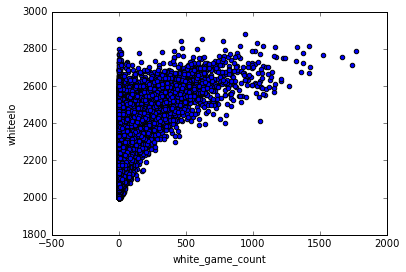

In [305]:
df.ix[df[['white','white_game_count','whiteelo']].groupby('white')['whiteelo'].idxmax()].plot('white_game_count','whiteelo',kind='scatter')

In [ ]:
plot of last updated rating as a function how many games for white 

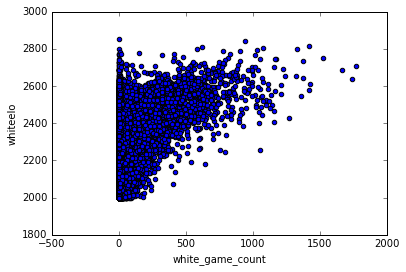

In [306]:
df.ix[df[['white','white_game_count','whiteelo','age']].groupby('white')['age'].idxmin()].plot('white_game_count','whiteelo',kind='scatter')

In [366]:
from math import log

This data exhibits heteroskedasticity

In [ ]:
plot of last updated rating as a function how many games for black

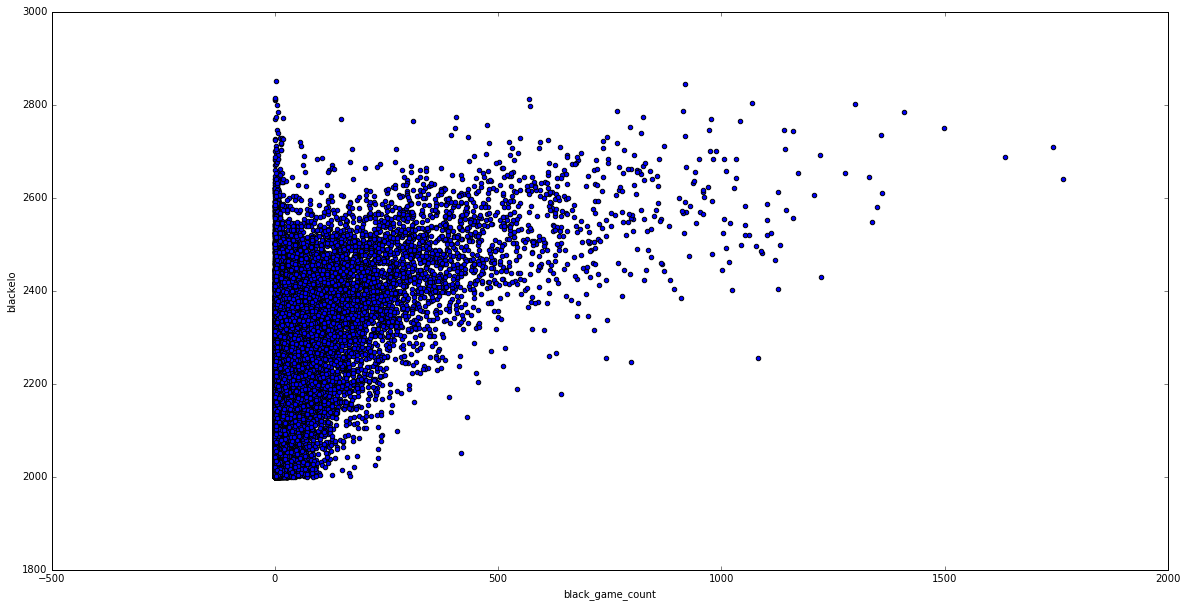

In [311]:
df.ix[df[['black','black_game_count','blackelo','age']].groupby('black')['age'].idxmin()].plot('black_game_count','blackelo',kind='scatter',figsize=(20,10))

In [58]:
from math import log10

In [59]:
rating_df = df

In [60]:
rating_df['lograting']= rating_df.whiteelo.map(log10,'whiteelo')

In [394]:
rating_df.head()

,black,blackelo,eco,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,white_enc,white_game_count,black_game_count,lograting
1785851,"Wahlstrom, Lennart",2132,C45,1.0,"Aaberg, Anton",2367,1.e4,e5,1642.0,0.823025,10468,75,18,3.374198
750696,"Gajic, Mladen",2248,B03,-1.0,"Aabling-Thomsen, Jakob",2329,1.e4,Nf6,263.0,0.657119,875,163,102,3.367169
1027098,"Nasri, Amin",2316,B40,-1.0,"Aadeli, Arvin",2015,1.e4,c5,1584.0,0.175305,44704,2,125,3.304275
467434,"Kersic, Matej",2207,D15,1.0,"Aagaard, Gert",2041,1.d4,d5,798.0,0.316184,31545,4,79,3.309843
1763382,"Ashton, Adam G",2385,C45,0.0,"Aagaard, Jacob",2498,1.e4,e5,276.0,0.697345,12282,439,208,3.397592


simple dummy model to use number of games in database to predict rating

In [310]:
rating_df = df.ix[df[['white','white_game_count','whiteelo','age']].groupby('white')['age'].idxmin()]

In [314]:
rating_df.head()

,black,blackelo,eco,result,white,whiteelo,white_first_move,black_first_move,age,estimate_white_win_by_rating,white_enc,white_game_count,black_game_count
1785851,"Wahlstrom, Lennart",2132,C45,1.0,"Aaberg, Anton",2367,1.e4,e5,1642.0,0.823025,10468,75,18
750696,"Gajic, Mladen",2248,B03,-1.0,"Aabling-Thomsen, Jakob",2329,1.e4,Nf6,263.0,0.657119,875,163,102
1027098,"Nasri, Amin",2316,B40,-1.0,"Aadeli, Arvin",2015,1.e4,c5,1584.0,0.175305,44704,2,125
467434,"Kersic, Matej",2207,D15,1.0,"Aagaard, Gert",2041,1.d4,d5,798.0,0.316184,31545,4,79
1763382,"Ashton, Adam G",2385,C45,0.0,"Aagaard, Jacob",2498,1.e4,e5,276.0,0.697345,12282,439,208


see below for simple linear regressor to predict rating vs number games in dataset.

# this is the start of more data engineering (find player style)...look at highest most used openings and then use the style

In [111]:
style_dict = {
'Mastermind':
{'White': ['Ruy Lopez (Spanish)', "Queen's Gambit"], 
 'Black': ['Ruy Lopez (Spanish)', 'French Defense']},

'Natural':
{'White': ['Ruy Lopez (Spanish)'], 
'Black': ['Sicilian Defense',"Queen's Indian"]},

'Prodigy':
{'White': ['Ruy Lopez (Spanish)', "Queen's Gambit"],
'Black': ['Ruy Lopez (Spanish)', 'Sicilian Defense', 'Grunfeld']},

'Professional':
{'White': ['Nimzo-Indian', 'English Opening'],
'Black': ['French Defense (Winawer)', 'Sicilian Defense']},

'Romantic':
{'White': ['Ruy Lopez (Spanish)'],
'Black': ['Sicilian Defense']},

'Surgeon':
{'White': ['Ruy Lopez (Spanish)'],
'Black': ['Ruy Lopez (Spanish)', "Queen's Gambit Declined (Orthodox Defense)"]},

'Technician':
{'White': ['English Opening'],
'Black': ['Sicilian Defense','Semi-Slav', 'Petrov Defense']},

'Anaconda':
{'White': ['Four Knights', 'Reti System'],
'Black': ['French Defense','Caro-Kann']},

'Assassin':
{'White': ['Ruy Lopez (Spanish)'],
'Black': ['Sicilian Defense (Najdorf)', "King's Indian"]},

'Barbarian':
{'White': ["Queen's Gambit"],
'Black': ['Sicilian Defense']},

'Champion':
{'White': ['Ruy Lopez (Spanish)',"Queen's Gambit"],
'Black': ['Sicilian Defense']},

'Escape Artist':
{'White': ['English Opening'],
'Black': ['French Defense'] }
}


#then i have to translate these word openings to their eco codes so I can count most frequent used ones.this essentially may be done already with the probabilities

In [19]:
df = df.drop_duplicates()  #viola better data = better data science

In [22]:
#clean up white game count, black game count, white opening count black opening count

In [23]:
savedf = df


In [24]:
#df.pop()
df.drop(['white_game_count','black_game_count','white_opening_count','black_opening_count'],inplace=True,axis=1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1791126 entries, 0 to 1861583
Data columns (total 25 columns):
black                           object
blackelo                        int64
eco                             object
moves                           object
result                          float64
white                           object
whiteelo                        int64
white_first_move                object
black_first_move                object
age                             float64
estimate_white_win_by_rating    float64
diff                            int64
white_enc                       int64
white_level                     object
black_level                     object
white_level_Expert              float64
white_level_GM                  float64
white_level_IM                  float64
white_level_Master              float64
white_level_Super GM            float64
black_level_Expert              float64
black_level_GM                  float64
black_level_IM         

In [26]:
catenc_b = pd.factorize(df['black'])
df['black_enc'] = catenc_b[0]
# get count of all of games played by the same player as white and black
df['white_game_count'] = df.groupby('white')['white'].transform('count')
df['black_game_count'] = df.groupby('black')['black'].transform('count')

#create some additional columsn to be used in probabilities...can refactor some dummy df later
#count of how many times white/black played same ECO
temp = df.groupby(['white','eco']).size().reset_index().rename(columns={0:'white_opening_count'})
temp2 = df.groupby(['black','eco']).size().reset_index().rename(columns={0:'black_opening_count'})
df = df.join(temp.set_index(['white','eco']), on=('white','eco'))
df = df.join(temp2.set_index(['black','eco']), on=('black','eco'))

#count of how many time white/black played the same first move
temp_m = df.groupby(['white','white_first_move']).size().reset_index().rename(columns={0:'white_fm_count'})
temp2_m = df.groupby(['black','black_first_move']).size().reset_index().rename(columns={0:'black_fm_count'})
df = df.join(temp2_m.set_index(['black','black_first_move']), on=('black','black_first_move'))
df = df.join(temp_m.set_index(['white','white_first_move']), on=('white','white_first_move'))

#calculate p(opening|color)
df['p_opening_given_white']=df['white_opening_count']/df['white_game_count']
df['p_opening_given_black']=df['black_opening_count']/df['black_game_count']

#calc p(fm|color)
df['p_wfm_given_white']=df['white_fm_count']/df['white_game_count']
df['p_bfm_given_black']=df['black_fm_count']/df['black_game_count']


In [ ]:
#win loss draw columns by players playing white
df.groupby('white')['result'].value_counts().head(1)
df.groupby(['white','eco'])['result'].value_counts().head(5)  # with opening groupby


In [30]:
#group by opening codes and give count for each white player
df.groupby(['eco'])['white'].value_counts().head(5)# with opening groupby


eco  white                 
A00  Movsziszian, Karen        134
     Petran, Peter             110
     Pel, Bonno                109
     Mestrovic, Zvonimir       104
     Haub, Thorsten Michael     94
Name: white, dtype: int64

In [39]:
#overall probability of opening occuring for either color
opening_count = df.groupby(['eco'])['eco'].value_counts()

In [42]:
opening_count  = df.groupby(['eco']).size().reset_index().rename(columns={0:'opening_count'})

In [44]:
df = df.join(opening_count.set_index(['eco']), on=('eco'))

In [45]:
df.head(2)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,black_game_count,white_opening_count,black_opening_count,black_fm_count,white_fm_count,p_opening_given_white,p_opening_given_black,p_wfm_given_white,p_bfm_given_black,opening_count
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,786,4,5,245,308,0.005739,0.006361,0.441894,0.311705,7826
1,"Ju, Wenjun",2558,A34,1.c4 c5 2.g3 Nf6 3.Bg2 d5 4.cxd5 Nxd5 5.Nc3 Nc...,-1.0,"Mkrtchian, Lilit",2434,1.c4,c5,261.0,...,503,4,1,198,133,0.008658,0.001988,0.287879,0.393638,5417


In [48]:
opening_count[opening_count.eco=='A34']

,eco,opening_count
34,A34,5417


In [56]:
df['p_opening'] = df.opening_count/df['black'].count()

In [ ]:
#play count * overall results is another feature
#df['white_eco_sucess']=

In [68]:
white_eco_result_agg=df.groupby(['white','eco'])['result'].sum().reset_index().rename(columns={'result':'w_eco_result_sum'})

In [69]:
black_eco_result_agg=df.groupby(['black','eco'])['result'].sum().reset_index().rename(columns={'result':'b_eco_result_sum'})

In [71]:
df = df.join(white_eco_result_agg.set_index(['white','eco']), on=('white','eco'))
df = df.join(black_eco_result_agg.set_index(['black','eco']), on=('black','eco'))


In [74]:
df['white_eco_sucess']=df.w_eco_result_sum*df.p_opening_given_white
#p_opening_given_white p_opening_given_black p_wfm_given_white p_bfm_given_black

In [75]:
df['black_eco_sucess']=df.b_eco_result_sum*df.p_opening_given_black

In [78]:
#do the same for the global population

In [76]:
eco_result_agg=df.groupby(['eco'])['result'].sum().reset_index().rename(columns={'result':'eco_result_sum'})


In [77]:
df = df.join(eco_result_agg.set_index(['eco']), on=('eco'))


In [79]:
df['eco_sucess']=df.eco_result_sum*df.p_opening

In [81]:
#pickle my df
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_final_master.pkl", "wb" ) )

In [92]:
df[['eco','eco_sucess','eco_result_sum']].sort('eco_sucess', ascending=False).drop_duplicates()

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,eco,eco_sucess,eco_result_sum
753930,B01,42.231418,3430.0
928332,B07,38.725847,2897.0
876103,B12,19.972053,2054.0
737733,D30,19.601890,2641.0
1232452,E11,16.714070,1818.0
1788787,C41,16.518999,2031.0
931857,B06,15.755971,1177.0
1151550,B33,14.284862,1322.0
1051291,B30,13.219677,1438.0
1373532,B90,12.187306,1315.0


In [ ]:
# after the above its interesting to note some findings based on popularity and results:
# best for white (bigger the better)
# 	eco	eco_sucess	eco_result_sum
# 753930	B01	42.231418	3430.0 scandinavian (blacks choice here)
# 928332	B07	38.725847	2897.0
# 876103	B12	19.972053	2054.0
# 737733	D30	19.601890	2641.0
# 1232452	E11	16.714070	1818.0
# 1788787	C41	16.518999	2031.0
# 931857	B06	15.755971	1177.0
# 1151550	B33	14.284862	1322.0
# 1051291	B30	13.219677	1438.0
# 1373532	B90	12.187306	1315.0
# 1846761	C42	12.147887	1996.0
#
# best for black (more negative the better)note lots of sicilians
# 97545	A03	-0.605545	-288.0
# 1002730	B44	-0.887073	-390.0
# 1195345	B20	-0.918087	-170.0
# 368962	A47	-0.978003	-337.0
# 1016080	B21	-1.028531	-438.0
# 1113224	B26	-1.217850	-526.0
# 1130786	B25	-1.572327	-621.0
# 1554196	C01	-1.755707	-309.0
# 1045984	B43	-2.431105	-403.0
# 374498	A48	-2.809370	-416.0
# 387943	A46	-7.565151	-889.0 


In [99]:
white_fm_result_agg=df.groupby(['white','white_first_move'])['result'].sum().reset_index().rename(columns={'result':'w_fm_result_sum'})
black_fm_result_agg=df.groupby(['black','black_first_move'])['result'].sum().reset_index().rename(columns={'result':'b_fm_result_sum'})
df = df.join(white_fm_result_agg.set_index(['white','white_first_move']), on=('white','white_first_move'))
df = df.join(black_fm_result_agg.set_index(['black','black_first_move']), on=('black','black_first_move'))


In [101]:
df['white_fm_success']=df.w_fm_result_sum*df.p_wfm_given_white
df['black_fm_success']=df.b_fm_result_sum*df.p_bfm_given_black

In [120]:
wfm_count = df.groupby(['white_first_move']).size().reset_index().rename(columns={0:'wfm_count'})
df = df.join(wfm_count.set_index(['white_first_move']), on=('white_first_move'))

In [126]:
df['p_wfm'] = df.wfm_count/df['white_first_move'].count()

bfm_count = df.groupby(['black_first_move']).size().reset_index().rename(columns={0:'bfm_count'})
df = df.join(bfm_count.set_index(['black_first_move']), on=('black_first_move'))
df['p_bfm'] = df.bfm_count/df['black_first_move'].count()

In [131]:
wfm_result_agg=df.groupby(['white_first_move'])['result'].sum().reset_index().rename(columns={'result':'wfm_result_sum'})



In [136]:
df['wfm_success']=df.wfm_result_sum*df.p_wfm

In [138]:
bfm_result_agg=df.groupby(['black_first_move'])['result'].sum().reset_index().rename(columns={'result':'bfm_result_sum'})
    

In [139]:
df = df.join(bfm_result_agg.set_index(['black_first_move']), on=('black_first_move'))
    

In [140]:
df['bfm_success']=df.bfm_result_sum*df.p_bfm

In [ ]:
wfm_result_agg=df.groupby(['white_first_move'])['result'].sum().reset_index().rename(columns={'result':'wfm_result_sum'})
df = df.join(wfm_result_agg.set_index(['white_first_move']), on=('white_first_move'))
#meant to measure success of opening at player levels


bfm_result_agg=df.groupby(['black_first_move'])['result'].sum().reset_index().rename(columns={'result':'bfm_result_sum'})
df = df.join(bfm_result_agg.set_index(['black_first_move']), on=('black_first_move'))
#meant to measure success of opening at player levels
df['bfm_success']=df.bfm_result_sum*df.p_bfm


In [142]:
#pickle my df
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/df_final_master2.pkl", "wb" ) )

In [115]:
import cPickle as pickle
pickle.dump(df, open( "../data/df_upload.pkl", "wb" ) )

In [6]:
cd src  # a bit more #combine the NB with GB

/Users/eduardodaroza/intro_dsi/capstone/Capstone/src


In [8]:
import cPickle as pickle
df = pickle.load( open( "../data/df_final.pkl", "rb" ) )

In [9]:
df = df.rename(columns = {'p_bfm_given_white':'p_bfm_given_black'})

In [ ]:
# what is the percentages of all openings and first moves for white and black

In [ ]:
#create a freq/percentage in pandas of these

In [ ]:
#look at which openings had the most wins/losses/draw for white and black

In [ ]:
#look at the openings that had the most upsets and fewest upsets

In [ ]:
#normalize and find the variety score by playrer

In [ ]:
#longest and shortest games (can we infer what this mean by the openings) 
-sorted win percentages by opening over the population as a whole...when the players are statistically rated the same...based on paper talking about the standard error or residuals...
i can measure the residuals of the actual results vs the eco code.  to do that is simply a subraction of the result from the estimation.

P(winning|opening)....hold all else = including the rating and check which openings have the most advantage for white and black  %wins/losses/draws)

In [ ]:
most frequent openings played in the first round/lastround

In [15]:
df['eco'].value_counts()  #most popular openings B22,B06,B07,B01,B33,B23,B12,B90,B30,E11,A45,D02
                          #E78 least popular

B22    39297
B06    24984
B07    24927
B01    23082
B33    20277
B23    18656
B12    18077
B90    17285
B30    17167
E11    17028
A45    16804
D02    16026
A46    15900
A07    15885
C41    15140
C11    14271
A30    13862
D30    13790
D11    13385
C02    13236
B42    12999
A40    12840
A41    12597
D00    12562
A48    12553
E15    12226
A04    12018
C45    11841
E94    11749
B40    11620
       ...  
A82      224
D67      221
B69      217
E22      208
D81      205
A78      204
A79      202
C23      201
D57      201
C79      188
D62      183
D84      175
C32      166
A71      166
D64      164
D65      145
A66      145
A72      142
D68      137
C35      135
D54      131
C38      120
A98      120
E79      118
E23      113
C37      111
A74      100
D69       77
A76       54
E78       40
Name: eco, dtype: int64

In [281]:
scandf = df[df['eco']=="B01"]
sicdf = df[df['eco']=="B22"]
robdf = df[df['eco']=="B06"]
pirc = df[df['eco']=="B07"]

In [289]:
fig = plt.figure(figsize=(16,12))
# Add a subplot
ax = fig.add_subplot()


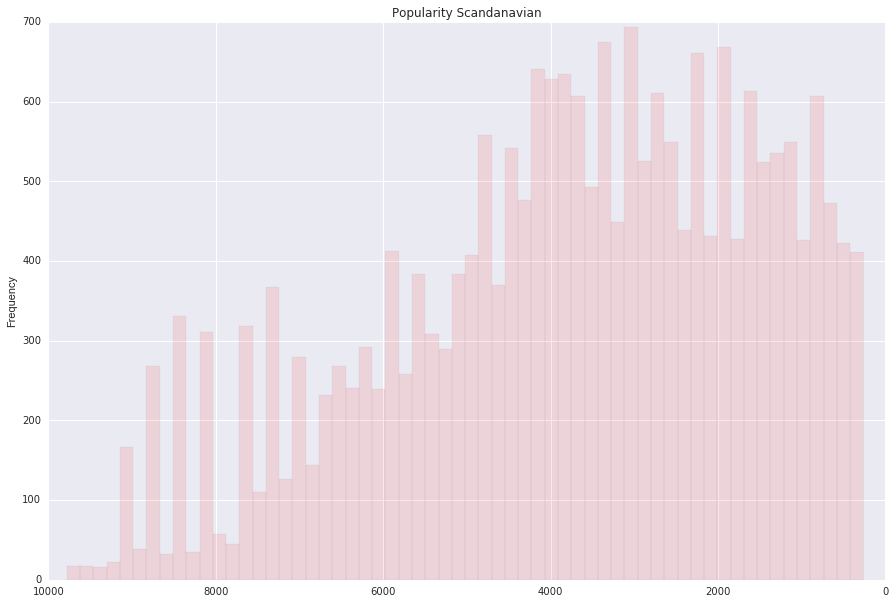

In [304]:
scandf[['white_first_move','age']].plot(kind='hist',bins=60,color='r',label='B01', alpha=0.1,legend=False,title='Popularity Scandanavian').invert_xaxis()

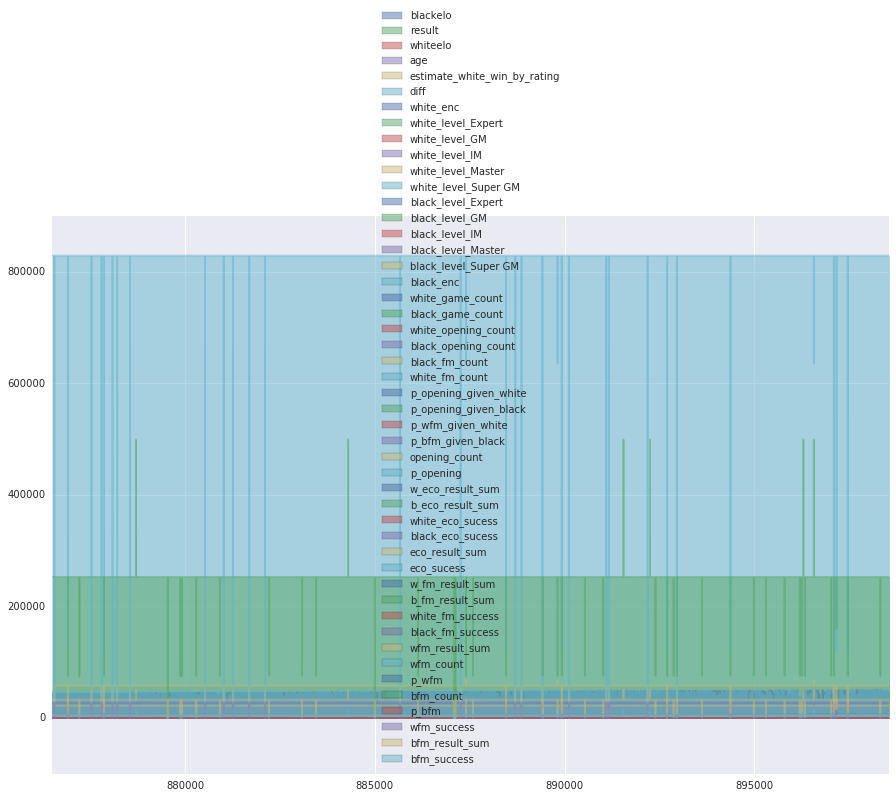

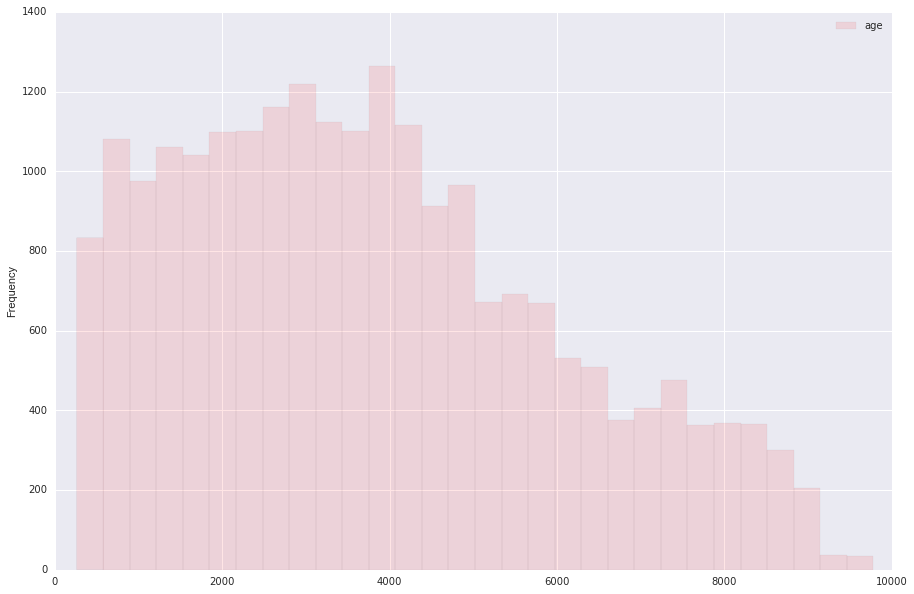

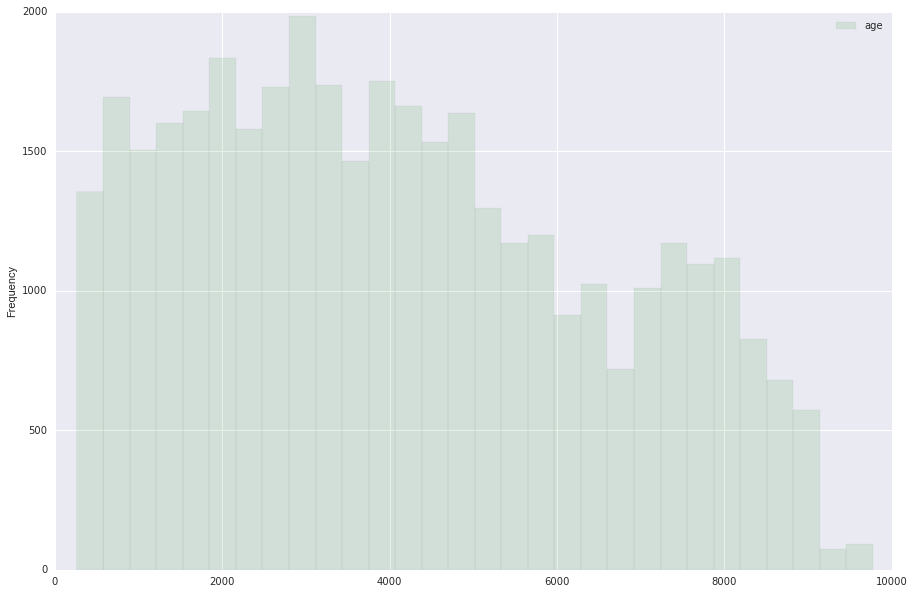

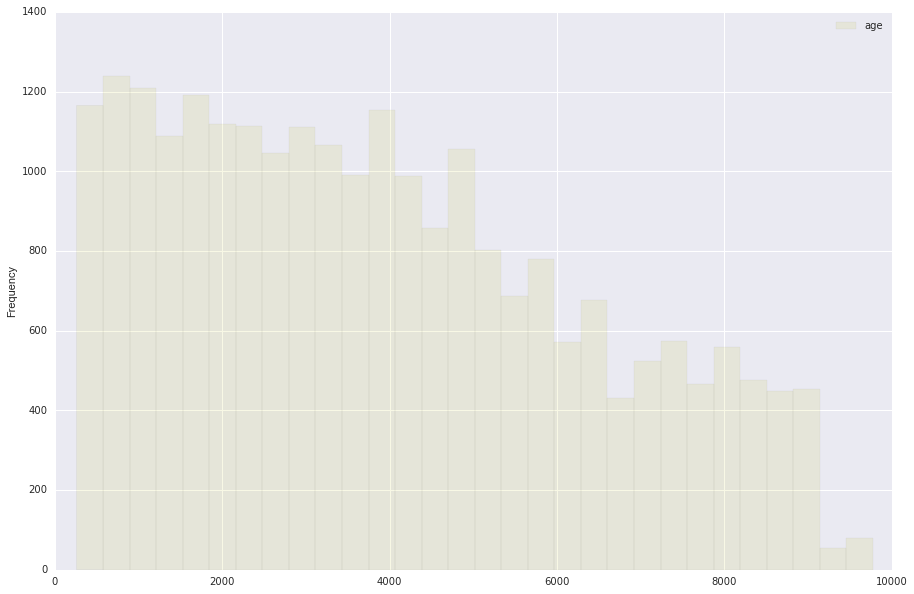

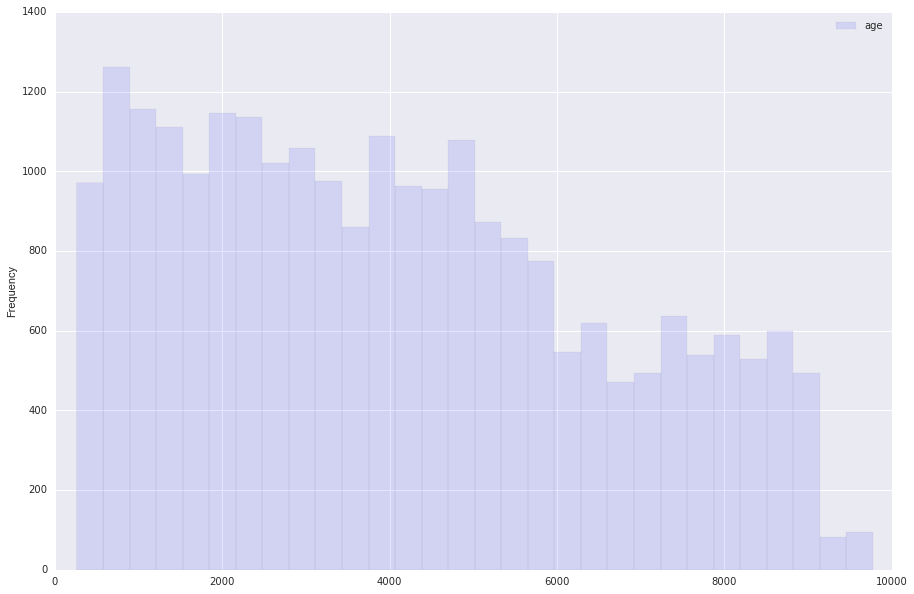

In [307]:
scandf.plot.area(stacked=False)
scandf[['white_first_move','age']].plot(kind='hist',bins=30,color='r',label='B01', alpha=0.1)
sicdf[['white_first_move','age']].plot(kind='hist',bins=30,color='g',label='B22', alpha=0.1)
robdf[['white_first_move','age']].plot(kind='hist',bins=30,color='y',label='B06', alpha=0.1)
pirc[['white_first_move','age']].plot(kind='hist',bins=30,color='b',label='B07', alpha=0.1)
#fig, ax = plt.subplots(1,1)
plt.show()

In [ ]:
load eco codes and try to regroup openings into larger subcategories

In [200]:
import cPickle as pickle
supergroups = pickle.load(open( "../data/supergroups.pkl", "rb" ) )

In [201]:
supergroups

,supergroups,sgmoves,groups,list_groups
0,A00 Polish (Sokolsky) opening,1. b4,A00,[A00]
1,A01 Nimzovich-Larsen attack,1. b3,A01,[A01]
2,A02-A03 Bird's opening,1. f4,A02-A03,"[A02, A03]"
3,A04-A09 Reti opening,1. Nf3,A04-A09,"[A04, A05, A06, A07, A08, A09]"
4,A10-A39 English opening,1. c4,A10-A39,"[A10, A11, A12, A13, A14, A15, A16, A17, A18, ..."
5,A40-A41 Queen's pawn,1. d4,A40-A41,"[A40, A41]"
6,"A42 Modern defence, Averbakh system",1. d4 d6 2. c4 g6 3. Nc3 Bg7 4. e4,A42,[A42]
7,A43-A44 Old Benoni defence,1. d4 c5,A43-A44,"[A43, A44]"
8,A45-A46 Queen's pawn game,1. d4 Nf6,A45-A46,"[A45, A46]"
9,A47 Queen's Indian defence,1. d4 Nf6 2. Nf3 b6,A47,[A47]


One unanticipated challenge was creating categorical information on the player names which was a feature that had a strongest correlation to the target value of predicting opening moves.  After I transitions from shard to the total dataset of 1.8 million games, I found that the data set had over 57,000 unique player names.  Using pandas pd.get_dummies method exceed my system memory and caused my kernel to crash.  

So for the final product I will need to investigate alternative solutions such as dividing this categorical labeling into subsets and then merging them.  Alternatively, Matt suggested that I investigate using the hash trick which would hash my unique features and reduce the dimension.  One consequence of the latter option would bucket users into arbitrary groups which may have some unwanted variance to the dataset.  Yet another suggestion from Miles would be to feature engineer some groups of player styles or classes to reduce dimensionality. Lastly, I could simply reduce the number of players by only keeping those that meet a threshold of minimum number of games for example > 3 games.  This would greatly reduce the dataset and potentially allow me to use the get_dummies method on all the data. I will explore these options in greater details in week two.

4. Modeling
---
In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific requirements on the form of data. Therefore, stepping back to the data preparation phase is often needed.


The other part of modeling that I needed to consider was if the player had little or no data in the database.  The solution that I decided on after some discussion with peers and instructors was to create a seperate model that had the player names removed and use this if the user entered name was't found in the data set.  In addition I may be able to use both the player based and non-player based models in some weighted ensemble to get the desired result of using a more general model if there was only a few games in the dataset.

In [20]:
df.head(1)

,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,black_level_Super GM,white_opening_count,black_opening_count,black_enc,black_fm_count,white_fm_count,p_opening_given_white,p_opening_given_black,p_wfm_given_white,p_bfm_given_white
0,"Kosteniuk, Alexandra",2554,A05,1.Nf3 Nf6 2.g3 b6 3.Bg2 Bb7 4.O-O e6 5.d3 d5 6...,-1.0,"Harika, Dronavalli",2511,1.Nf3,Nf6,261.0,...,0.0,4,5,0,249,324,0.005427,0.006227,0.43962,0.310087


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1791126 entries, 0 to 1861583
Data columns (total 56 columns):
black                           object
blackelo                        int64
eco                             object
moves                           object
result                          float64
white                           object
whiteelo                        int64
white_first_move                object
black_first_move                object
age                             float64
estimate_white_win_by_rating    float64
diff                            int64
white_enc                       int64
white_level                     object
black_level                     object
white_level_Expert              float64
white_level_GM                  float64
white_level_IM                  float64
white_level_Master              float64
white_level_Super GM            float64
black_level_Expert              float64
black_level_GM                  float64
black_level_IM         

In [ ]:
#need to refactor code to label player levels to remove caps and space for GM

In [133]:
#modeling
y = df['white_first_move'].values
y_eco = df['eco'].values
#X = df[['blackelo','result','whiteelo','age','estimate_white_win_by_rating']].values
##X = df[['blackelo','whiteelo','age','white_enc','result','estimate_white_win_by_rating']].values
#this takes out result so i can use NB...result didn't have much impact on prev models so will look 
#at FE with possible * with probability of white playing
X = (df[['blackelo','whiteelo','age','white_enc','black_enc','white_level_Expert',
         'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
         'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
         'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
         'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
         'p_bfm_given_white','estimate_white_win_by_rating']].values)
X_nouser = (df[['blackelo','whiteelo','age','white_level_Expert',
         'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
         'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
         'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
         'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
         'p_bfm_given_white','estimate_white_win_by_rating']].values)
X_simple = (df[['blackelo','whiteelo','p_opening','opening_count','eco_success','result','eco_result_sum','bfm_success','wfm_success']].values)

#trainsplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_train_nouser, X_test_nouser, y_train_nouser, y_test_nouser = train_test_split(X_nouser, y, test_size=0.30, random_state=42)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import tree
#class_weight=
clf1 = LogisticRegression(random_state=123, multi_class='ovr')
clf2 = RandomForestClassifier(random_state=123,n_estimators=100, n_jobs=-1)
clf3 = GaussianNB()
clf4 = MultinomialNB()
clf5 = tree.DecisionTreeClassifier()

y_pred = clf1.fit(X_train, y_train).predict(X_test)
#y_pred = clf1_nouser.fit(X_train_nouser, y_train_nouser).predict(X_test_nouser)
#y_pred = clf2.fit(X_train, y_train).predict(X_test)



In [132]:
clf1_nouser = clf1

pickle model to use for app

In [134]:
import cPickle as pickle
pickle.dump(clf1, open( "../data/model_log.pkl", "wb" ) )

In [98]:
pickle.dump(clf1, open( "../data/model_log_nouser.pkl", "wb" ) )

In [78]:
pickle.dump(clf2, open( "../data/model_rfc.pkl", "wb" ) )

Next to include GB model as this address bias better than other models and the fact that trees are building off the residuals will likely help with the size compared to RF which was over 40GB.  Also, would like to explore graphlab recommender system just to see how it does vs these classifiers though this will have to be after the project due to time constraints. 

Additional:Curious to see how well I can model rating, I tried a simple linear regressor based on days.  Mixed results. I think that there are better ways to featurize the data here to get a better result but justed wanted to run a quick experiment before GBC testing.

In [61]:
#modeling
#y_rating = rating_df['whiteelo'].values
y_rating = rating_df['lograting'].values
X_rating = rating_df['white_game_count']
X_rating = X_rating.reshape(-1, 1) 

%matplotlib inline
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

#trainsplit
from sklearn.model_selection import train_test_split
X_rating_train, X_rating_test, y_rating_train, y_rating_test = train_test_split(X_rating, y_rating, test_size=0.30, random_state=42)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import tree

#poly = PolynomialFeatures(degree=2)
#X_ = poly.fit_transform(X_rating)
#predict_ = poly.fit_transform(y_rating)
#class_weight='balanced'
clf = LinearRegression()
y_rating_pred = clf.fit(X_rating_train, y_rating_train).predict(X_rating_test)




In [442]:
pow(10,clf.predict(110)[0])

2236.7687659478479

In [447]:
clf.coef_

array([ 0.00013857])

In [452]:
from sklearn.feature_selection import f_regression

Gradient boosted classifier

In [63]:
from sklearn.ensemble import GradientBoostingClassifier #max_features sqrt n = 5 will reduce the variance

In [122]:
est = GradientBoostingClassifier(n_estimators=50, max_depth=4, learning_rate=0.1) #learning rate went way down with , max_features=5, subsample=0.9
est.fit(X_train, y_train)

# predict class labels
pred = est.predict(X_test)

# score on test data (accuracy)
acc = est.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est.predict_proba(X_test)[0]

ACC: 0.6356


array([  2.94369560e-04,   8.49039487e-04,   2.81022713e-02,
         2.94337253e-04,   3.05344159e-04,   2.94243129e-04,
         5.18917959e-04,   3.94423198e-04,   3.14819473e-04,
         3.18004336e-02,   3.65281787e-04,   3.18411267e-01,
         3.62728848e-04,   6.14808471e-01,   2.94793437e-04,
         4.42338681e-04,   1.26276754e-03,   2.94222431e-04,
         2.95259308e-04,   2.94670784e-04])

In [123]:
y_pred = est.predict(X_test)
clf_probs = est.predict_proba(X_test)
score = log_loss(y_test, clf_probs)
print accuracy_score(y_test, y_pred)
print score

0.635612326944
0.837877582308


In [124]:
score

0.8378775823083614

In [126]:
pickle.dump(est, open( "../data/model_gbc.pkl", "wb" ) )

In [130]:
est.predict([2.37000000e+03,   2.16300000e+03,   3.47400000e+03,
         1.29850000e+04,   1.08010000e+04,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.00000000e+00,   5.00000000e+00,   1.90000000e+01,
         9.20000000e+01,   4.34782609e-02,   2.65957447e-02,
         1.00000000e+00,   1.01063830e-01,   2.67492710e-01])

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array(['1.e4'], dtype=object)

prior attempts

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False
63%acc on train data

no user

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=4,
              max_features=5, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.9, verbose=0, warm_start=False)
%.0079 accuracy was very low

In [1]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


gbc on y_eco

restart here

In [2]:
import cPickle as pickle
df = pickle.load( open( "../data/df_upload.pkl", "rb" ) )

In [3]:
y_eco = df['eco'].values
#X = df[['blackelo','result','whiteelo','age','estimate_white_win_by_rating']].values
##X = df[['blackelo','whiteelo','age','white_enc','result','estimate_white_win_by_rating']].values
#this takes out result so i can use NB...result didn't have much impact on prev models so will look 
#at FE with possible * with probability of white playing
X = (df[['blackelo','whiteelo','age','white_enc','black_enc','white_level_Expert',
         'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
         'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
         'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
         'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
         'p_bfm_given_white','estimate_white_win_by_rating']].values)
X_nouser = (df[['blackelo','whiteelo','age','white_level_Expert',
         'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
         'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
         'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
         'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
         'p_bfm_given_white','estimate_white_win_by_rating']].values)
#trainsplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_eco, test_size=0.30, random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier 
est2 = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1) #learning rate went way down with , max_features=5, subsample=0.9
est2.fit(X_train, y_train)

# predict class labels
pred = est2.predict(X_test)

# score on test data (accuracy)
acc = est2.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est2.predict_proba(X_test)[0]

In [2]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


In [4]:
#pickle my df
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
df = pickle.load(open( "../data/df_final_master2.pkl", "rb" ) )

In [8]:
ak_df = df[(df.white == "Kosteniuk, Alexandra") | (df.black == "Kosteniuk, Alexandra")]

In [39]:
#modeling
y = ak_df['white_first_move'].values
y_eco = ak_df['eco'].values
#X = df[['blackelo','result','whiteelo','age','estimate_white_win_by_rating']].values
##X = df[['blackelo','whiteelo','age','white_enc','result','estimate_white_win_by_rating']].values
#this takes out result so i can use NB...result didn't have much impact on prev models so will look 
#at FE with possible * with probability of white playing
# X = (df[['blackelo','whiteelo','age','white_enc','black_enc','white_level_Expert',
#          'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
#          'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
#          'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
#          'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
#          'p_bfm_given_white','estimate_white_win_by_rating']].values)
# X_nouser = (df[['blackelo','whiteelo','age','white_level_Expert',
#          'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
#          'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
#          'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
#          'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
#          'p_bfm_given_white','estimate_white_win_by_rating']].values)
X = (ak_df[['age',
         'b_eco_result_sum',
         'b_fm_result_sum',
         'bfm_result_sum',
         'bfm_success',
         'black_eco_sucess',
         'black_enc',
         'black_fm_count',
         'black_fm_success',
         'black_game_count',
         'black_opening_count',
         'blackelo',
         'eco_result_sum',
         'eco_sucess',
         'opening_count',
         'p_bfm',
         'p_bfm_given_black',
         'p_opening',
         'p_opening_given_black',
         'p_opening_given_white',
         'p_wfm',
         'bfm_count',
         'p_wfm_given_white',
         'w_eco_result_sum',
         'w_fm_result_sum',
         'wfm_count',
         'wfm_result_sum',
         'wfm_success',
         'white_eco_sucess',
         'white_fm_count',
         'white_fm_success',
         'white_game_count',
         'white_opening_count',
         'whiteelo']].values)

#trainsplit
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

# X_train_nouser, X_test_nouser, y_train_nouser, y_test_nouser = train_test_split(X_nouser, y, test_size=0.30, random_state=42)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import tree
#class_weight=
clf1 = LogisticRegression(random_state=123, multi_class='ovr')
clf2 = (RandomForestClassifier(random_state=123,n_estimators=20, n_jobs=-1))
clf3 = GaussianNB()
clf4 = MultinomialNB()
clf5 = tree.DecisionTreeClassifier()

y_pred = clf2.fit(X_train, y_train).predict(X_test)
#y_pred = clf1_nouser.fit(X_train_nouser, y_train_nouser).predict(X_test_nouser)
#y_pred = clf2.fit(X_train, y_train).predict(X_test)
# from sklearn import svm
# from sklearn.model_selection import cross_val_score
# svc_clf = svm.SVC(kernel='linear', C=1)
# scores = cross_val_score(svc_clf, X, y, cv=5)
#scores                                              
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# from sklearn import metrics
# scores = cross_val_score(
# ...     clf, iris.data, iris.target, cv=5, scoring='f1_macro')
# scores 


In [ ]:
from sklearn.metrics import log_loss, f1_score,accuracy_score
clf_probs = clf2.predict_proba(X_test,y_test)
score = log_loss(y_test, clf_probs)
print accuracy_score(y_test, y_pred)
print score

In [68]:
set(y_test)

{'1.Nf3', '1.b3', '1.c3', '1.c4', '1.d4', '1.e4'}

In [72]:
#favorite_color = { "lion": "yellow", "kitty": "red" }
pickle.dump(df, open( "../data/ak_rfc.pkl", "wb" ) )

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y_eco, test_size=0.30, random_state=42)

In [ ]:
clf2_eco = (RandomForestClassifier(random_state=123,n_estimators=20, n_jobs=-1))
clf3 = GaussianNB()
clf4 = MultinomialNB()
clf5 = tree.DecisionTreeClassifier()

y_pred = clf2_eco.fit(X_train, y_train).predict(X_test)

In [74]:
from sklearn.ensemble import GradientBoostingClassifier 
est2 = GradientBoostingClassifier(n_estimators=10, max_depth=4, learning_rate=0.1) #learning rate went way down with , max_features=5, subsample=0.9
est2.fit(X_train, y_train)

# predict class labels
pred = est2.predict(X_test)

# score on test data (accuracy)
acc = est2.score(X_test, y_test)
print('ACC: %.4f' % acc)

# predict class probabilities
est2.predict_proba(X_test)[0]

ACC: 0.6348


array([ 0.00411802,  0.00411424,  0.00410667,  0.00412175,  0.00410669,
        0.00416367,  0.00411423,  0.00445103,  0.00412559,  0.00457552,
        0.00410668,  0.00426358,  0.00410668,  0.00410665,  0.00411042,
        0.00411423,  0.00411045,  0.00496962,  0.00411801,  0.00451206,
        0.00411042,  0.00410667,  0.00412382,  0.00411919,  0.0044147 ,
        0.00412541,  0.00411789,  0.00411788,  0.00410663,  0.00410663,
        0.00410663,  0.00411411,  0.00499323,  0.00410662,  0.00415431,
        0.00410661,  0.00421478,  0.00411039,  0.00411788,  0.00416702,
        0.00410661,  0.00412162,  0.00466029,  0.00418879,  0.00411035,
        0.00415241,  0.00413423,  0.00572366,  0.00411167,  0.00420387,
        0.00415691,  0.00411035,  0.00410658,  0.00413469,  0.00413098,
        0.00410834,  0.00443717,  0.00413846,  0.00410834,  0.00411961,
        0.00419482,  0.00415563,  0.00413289,  0.00440823,  0.00411209,
        0.00411412,  0.00410833,  0.00411584,  0.00411208,  0.00

In [ ]:
from sklearn.metrics import log_loss, f1_score,accuracy_score
clf_probs = est2.predict_proba(X_test)
score = log_loss(y_test, clf_probs)
print accuracy_score(y_test, pred)
print score

In [88]:
pickle.dump(df, open( "../data/ak_gb_eco.pkl", "wb" ) )

In [ ]:
#build gbc with names for eco

In [2]:
cd games

/Users/eduardodaroza/intro_dsi/capstone/Capstone/games


In [141]:
# import cPickle as pickle 
# df=pickle.load(open( "../data/df_final_master2.pkl", "rb" ) )
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingClassifier 
# from sklearn.preprocessing import StandardScaler
ak_df = df[(df.white == 'Ju, Wenjun')] #df[(df.white=='Kosteniuk, Alexandra')]
#ak_df = df[(df.white=='Kosteniuk, Alexandra')|df.black=='Kosteniuk, Alexandra')]
y = ak_df['white_first_move'].values
y2 = ak_df['black_first_move'].values
y_eco = ak_df['eco'].values
X = (ak_df[['blackelo',
# y = df['white_first_move'].values
# y2 = df['black_first_move'].values
# y_eco = df['eco'].values
# X = (df[['blackelo',
'result',
 'whiteelo',
 'age',
 'estimate_white_win_by_rating',
'diff',
 'white_enc',
 'white_level_Expert',
 'white_level_GM',
 'white_level_IM',
 'white_level_Master',
 'white_level_Super GM',
 'black_level_Expert',
 'black_level_GM',
 'black_level_IM',
 'black_level_Master',
 'black_level_Super GM',
 'black_enc',
 'white_game_count',
 'black_game_count',
 'white_opening_count',
 'black_opening_count',
 'black_fm_count',
 'white_fm_count',
 'p_opening_given_white',
 'p_opening_given_black',
 'p_wfm_given_white',
 'p_bfm_given_black',
 'opening_count',
 'p_opening',
'w_eco_result_sum',
'b_eco_result_sum',
'white_eco_sucess',
'black_eco_sucess',
'eco_result_sum',
'eco_sucess',
'w_fm_result_sum',
'b_fm_result_sum',
'white_fm_success',
'black_fm_success',
'wfm_result_sum',
 'wfm_count',
 'p_wfm',
 'bfm_count',
 'p_bfm',
'wfm_success',
'bfm_result_sum',
'bfm_success'
        ]].values)

#X = StandardScaler().fit_transform(X)  scaling data didn't improve modeling performance

#trainsplit
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_eco, test_size=0.20, random_state=42)
# from sklearn.naive_bayes import MultinomialNB
# nbclf = MultinomialNB()
# nbclf.fit(X_train, y_train)

est3 = GradientBoostingClassifier(n_estimators=300, max_depth=5, learning_rate=0.01,max_features=6, subsample=0.95) 
#learning rate went way down with , max_features=5, subsample=0.9

#est3 = GradientBoostingClassifier(n_estimators=1, max_depth=3, learning_rate=0.1,max_features=6,subsample=0.9) 
#learning rate went way down with , max_features=5, subsample=0.9
est3.fit(X_train, y_train)

# predict class labels
#pred = est3.predict(X_test)

# score on test data (accuracy)
#acc = est3.score(X_test, y_test)
#print('ACC: %.4f' % acc)

#predict class probabilities
#est3.predict_proba(X_test)[0]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=6, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=None,
              subsample=0.95, verbose=0, warm_start=False)

In [142]:
pred = est3.predict_proba(X_test)

In [143]:
pred

array([[  4.54543317e-04,   4.52341886e-04,   6.15150810e-04, ...,
          4.54555694e-04,   4.55641089e-04,   4.52341509e-04],
       [  4.58062851e-05,   4.55838241e-05,   4.59120003e-05, ...,
          4.66957293e-05,   4.95310903e-05,   4.77002024e-05],
       [  5.46956146e-03,   5.44302310e-03,   5.60886205e-03, ...,
          5.46965218e-03,   5.48271758e-03,   5.44309033e-03],
       ..., 
       [  5.57135351e-03,   5.67051950e-03,   5.58418479e-03, ...,
          5.57142911e-03,   5.58471933e-03,   8.19920721e-03],
       [  4.63372008e-03,   4.70426361e-03,   4.64435937e-03, ...,
          5.54664157e-03,   4.73384400e-03,   5.01225706e-03],
       [  1.61462062e-04,   1.60677935e-04,   1.64897420e-04, ...,
          9.72971350e-01,   1.92473144e-04,   1.60684014e-04]])

In [144]:
#score on test data (accuracy)
acc = est3.score(X_test, y_test)
print('ACC: %.4f' % acc)

#predict class probabilities
#est3.predict_proba(X_test)[0]

ACC: 0.7184


In [145]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import log_loss
y_pred = est3.predict(X_test) 
clf_probs = est3.predict_proba(X_test)
#score = log_loss(y_test, clf_probs)

In [190]:
ak_df = df[(df.white=='Kosteniuk, Alexandra')]
y_eco = ak_df['eco'].values
X = (ak_df[[#'blackelo',
# y = df['white_first_move'].values
# y2 = df['black_first_move'].values
# y_eco = df['eco'].values
# X = (df[['blackelo',
# 'result',
# 'whiteelo',
# 'age',
#'estimate_white_win_by_rating',
#'diff',
#  'white_enc',
#  'white_level_Expert',
#  'white_level_GM',
#  'white_level_IM',
#  'white_level_Master',
#  'white_level_Super GM',
#  'black_level_Expert',
#  'black_level_GM',
#  'black_level_IM',
#  'black_level_Master',
#  'black_level_Super GM',
#  'black_enc',
#  'white_game_count',
#  'black_game_count',
# 'white_opening_count',
#  'black_opening_count',
#  'black_fm_count',
#  'white_fm_count',
  'p_opening_given_white',
#  'p_opening_given_black',
#  'p_wfm_given_white',
#  'p_bfm_given_black',
# 'opening_count',
# 'p_opening',
# 'w_eco_result_sum',
# 'b_eco_result_sum',
# 'white_eco_sucess',
# 'black_eco_sucess',
#'eco_result_sum',
#'eco_sucess',
# 'w_fm_result_sum',
# 'b_fm_result_sum',
# 'white_fm_success',
# 'black_fm_success',
# 'wfm_result_sum',
#  'wfm_count',
# 'p_wfm',first
#  'bfm_count',
# 'p_bfm',
#'wfm_success',
#'bfm_result_sum',
#'bfm_success'
        ]].values)

#X = StandardScaler().fit_transform(X)  scaling data didn't improve modeling performance

#trainsplit
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y_eco, test_size=0.20, random_state=42)
from sklearn.naive_bayes import MultinomialNB
nbclf = MultinomialNB()
nbclf.fit(X_train, y_train)


#Lets just try simple NaiveBayes

#est3 = GradientBoostingClassifier(n_estimators=1, max_depth=5, learning_rate=1,max_features=6, subsample=0.95) 
#learning rate went way down with , max_features=5, subsample=0.9

#est3 = GradientBoostingClassifier(n_estimators=1, max_depth=3, learning_rate=0.1,max_features=6,subsample=0.9) 
#learning rate went way down with , max_features=5, subsample=0.9
#est3.fit(X_train, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [191]:
# predict class labels
pred = nbclf.predict(X_test)

# score on test data (accuracy)
acc = nbclf.score(X_test, y_test)
print('ACC: %.4f' % acc)

#predict class probabilities
#nbclf.predict_proba(X_test)[0]

ACC: 0.0764


Low accuracy.

In [193]:
len(nbclf.classes_)

153

In [188]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import log_loss
y_pred = nbclf.predict(X_test) 
clf_probs = nbclf.predict_proba(X_test)
score = log_loss(y_test, clf_probs, labels=['A35', 'A36', 'A57', 'A60', 'A61', 'A77', 'A83', 'A87', 'B00',
       'B01', 'B02', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B15', 'B16', 'B19', 'B20', 'B22', 'B23', 'B27', 'B28',
       'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38',
       'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B47', 'B49', 'B51',
       'B52', 'B53', 'B57', 'B60', 'B61', 'B63', 'B64', 'B65', 'B66',
       'B67', 'B72', 'B74', 'B76', 'B80', 'B81', 'B82', 'B83', 'B84',
       'B85', 'B90', 'B92', 'B94', 'B96', 'B97', 'B98', 'B99', 'C00',
       'C02', 'C03', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11',
       'C12', 'C13', 'C14', 'C15', 'C16', 'C18', 'C24', 'C25', 'C28',
       'C29', 'C40', 'C41', 'C42', 'C43', 'C45', 'C47', 'C50', 'C54',
       'C55', 'C58', 'C60', 'C61', 'C63', 'C64', 'C65', 'C67', 'C68',
       'C70', 'C74', 'C75', 'C76', 'C77', 'C78', 'C80', 'C82', 'C83',
       'C84', 'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C95',
       'C96', 'C97', 'D00', 'D01', 'D03', 'D10', 'D12', 'D15', 'D20',
       'D26', 'D31', 'D37', 'D38', 'D45', 'D48', 'D52', 'D94', 'E10',
       'E11', 'E12', 'E17', 'E32', 'E68', 'E81', 'E91', 'E94', 'E97'])

In [194]:
score

4.1540128347262844

NB acc over the entire dataset...without player names was 4.30%

score: logloss was 4.65% over the entire dataset

In [166]:
score

4.6512181183684298

#build gbc with no names for eco

In [110]:
pickle.dump(df, open( "../data/gbc_wfm_names.pkl", "wb" )) #ACC=.9985 (overfit?),F1-score_macro=.914, logloss=.309

In [117]:
names= ['blackelo',
 'result',
 'whiteelo',
 'age',
 'estimate_white_win_by_rating',
 'diff',
 'white_enc',
 'white_level_Expert',
 'white_level_GM',
 'white_level_IM',
 'white_level_Master',
 'white_level_Super GM',
 'black_level_Expert',
 'black_level_GM',
 'black_level_IM',
 'black_level_Master',
 'black_level_Super GM',
 'black_enc',
 'white_game_count',
 'black_game_count',
 'white_opening_count',
 'black_opening_count',
 'black_fm_count',
 'white_fm_count',
 'p_opening_given_white',
 'p_opening_given_black',
 'p_wfm_given_white',
 'p_bfm_given_black',
 'opening_count',
 'p_opening',
 'w_eco_result_sum',
 'b_eco_result_sum',
 'white_eco_sucess',
 'black_eco_sucess',
 'eco_result_sum',
 'eco_sucess',
 'w_fm_result_sum',
 'b_fm_result_sum',
 'white_fm_success',
 'black_fm_success',
 'wfm_result_sum',
 'wfm_count',
 'p_wfm',
 'bfm_count',
 'p_bfm',
 'wfm_success',
 'bfm_result_sum',
 'bfm_success']
test= sorted(zip(map(lambda x: round(x,4), est3.feature_importances_),names),reverse=True);test
#clf2.feature_importances_

[(0.2196, 'bfm_count'),
 (0.2161, 'bfm_success'),
 (0.2045, 'bfm_result_sum'),
 (0.1613, 'p_bfm'),
 (0.0298, 'opening_count'),
 (0.0279, 'eco_sucess'),
 (0.0244, 'wfm_success'),
 (0.0243, 'p_opening'),
 (0.0183, 'wfm_result_sum'),
 (0.0183, 'p_wfm'),
 (0.0138, 'wfm_count'),
 (0.0097, 'eco_result_sum'),
 (0.0082, 'p_bfm_given_black'),
 (0.0062, 'black_eco_sucess'),
 (0.004, 'p_opening_given_black'),
 (0.0021, 'p_wfm_given_white'),
 (0.0016, 'black_fm_count'),
 (0.0015, 'black_fm_success'),
 (0.0012, 'white_fm_success'),
 (0.0011, 'b_fm_result_sum'),
 (0.001, 'whiteelo'),
 (0.0008, 'age'),
 (0.0007, 'diff'),
 (0.0006, 'blackelo'),
 (0.0005, 'black_opening_count'),
 (0.0005, 'black_enc'),
 (0.0005, 'b_eco_result_sum'),
 (0.0004, 'estimate_white_win_by_rating'),
 (0.0003, 'white_enc'),
 (0.0002, 'w_eco_result_sum'),
 (0.0002, 'p_opening_given_white'),
 (0.0002, 'black_game_count'),
 (0.0001, 'white_opening_count'),
 (0.0001, 'white_eco_sucess'),
 (0.0, 'white_level_Super GM'),
 (0.0, 'whit

In [118]:
pickle.dump(df, open( "../data/gbc_bfm_names.pkl", "wb" )) #ACC=.9985,F1-score_macro=.914, logloss=.309

In [114]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import log_loss
y_pred = est3.predict(X_test) 
clf_probs = est3.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [115]:
accuracy_score(y_test, y_pred)

0.99992741998518619

In [116]:
f1_score(y_test, y_pred, average='macro') 

0.9551133912856562

In [103]:
score

0.30894496538978045

In [111]:
from sklearn.metrics import roc_auc_score

In [ ]:
#roc_auc_score(y_test,clf_probs)

In [109]:
est3

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=6, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=None,
              subsample=0.9, verbose=0, warm_start=False)

# the main concern I have with probabilities are that they may be a form of leakage.  Or at the very least these have to be stored in a lokup table and recalculated as more games are inserted into the dataset.  So will look at only using a few for the final models.


5. Evaluation
---
At this stage in the project you have built a model (or models) that appears to have high quality, from a data analysis perspective. Before proceeding to final deployment of the model, it is important to more thoroughly evaluate the model, and review the steps executed to construct the model, to be certain it properly achieves the business objectives. A key objective is to determine if there is some important business issue that has not been sufficiently considered. At the end of this phase, a decision on the use of the data mining results should be reached.


Summary: Initial modeling provided poor predictive power especially when moving to using the larger dataset without player name. Later attempts with name (which turned out to be the feature with most importance for the models) demonstrated GradientBoosting to perform best with respect to logloss but it took a long time to train on my system (4 core apple mac book).  In one early approach which yielded superior accuracy and f scores, I filtered the dataset by player by querying on player name against a db and building an individual model based on player but that seems less than ideal as the model assumes that a player will only play what they played before.  However that makes that model completely unaware of other target classes so any other opening moves or eco codes except what was in his/her previous repetoire gives 0% chance of playing anything new.  I think an ensemble of different models in combination of NaiveBayes would more accurately model of reality. Due to time constraints I settled on using XGBoost package to model based on entire dataset (with all targets would be included) so that I could use EC2 instance with 16/32 cores to help gridsearch for parameter turning and train the model.  I built two XGBoost models(both including the name feature where removing names can be done after the project), one for first move and one for opening ECO codes grouped together by superclasses (66) to improve accuracy as derived for the higher order of ECO families based on similar positions/structures. I conducted a for the supergroups model on 3 paramters: to be max_depth=5 (for [1,3,5] combinations) with min_child_weight=1 (for [1,3,5] combinations) and holding those constant I found that max_delta_step (a param in xgboost to help with the imbalanced classes) to be 3 (for [1,3,5] combinations).  The alternate way to handle imbalanced classes in xgboost is to use the param sample_pos_weight which I can experiment with after the class.

http://scikit-learn.org/stable/modules/cross_validation.html  use cross_val to score f1_macro for mult classifier

In [28]:
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import log_loss

clf_probs = clf1.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [29]:
accuracy_score(y_test, y_pred)

0.50098760966227873

In [30]:
f1_score(y_test, y_pred, average='micro') 

0.50098760966227873

In [31]:
score

1.0665213943443967

In [79]:
# acc = clf1.score(X_test, y_test)
# print('ACC: %.4f' % acc)

no use info


In [93]:
clf_probs = clf1.predict_proba(X_test_nouser)
score = log_loss(y_test_nouser, clf_probs)

In [94]:
score

1.0506690434309069

In [95]:
accuracy_score(y_test, y_pred)

0.51349434743445332

to get feature importance:

In [ ]:
feature importance
zip(model.classes_,model.predict_proba(X_test))

rfc (100 trees)

In [49]:
clf_probs = clf2.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [50]:
accuracy_score(y_test, y_pred)

0.78607640499338316

In [51]:
score

0.65984409068508587

In [54]:
names=['blackelo','whiteelo','age','white_enc','black_enc','white_level_Expert',
         'white_level_GM','white_level_IM','white_level_Master','white_level_Super GM',
         'black_level_Expert','black_level_GM','black_level_IM','black_level_Master',
         'black_level_Super GM','white_opening_count','black_opening_count','black_fm_count',
         'white_fm_count', 'p_opening_given_white','p_opening_given_black','p_wfm_given_white',
         'p_bfm_given_white','estimate_white_win_by_rating']
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x,4), clf2.feature_importances_),names),reverse=True)

Features sorted by their score:
[(0.1654, 'white_enc'), (0.1506, 'p_wfm_given_white'), (0.0981, 'white_fm_count'), (0.0636, 'p_opening_given_white'), (0.0625, 'p_bfm_given_white'), (0.0606, 'age'), (0.0585, 'whiteelo'), (0.0574, 'p_opening_given_black'), (0.0557, 'black_enc'), (0.0503, 'blackelo'), (0.0498, 'estimate_white_win_by_rating'), (0.0494, 'black_fm_count'), (0.0329, 'white_opening_count'), (0.03, 'black_opening_count'), (0.0022, 'white_level_Master'), (0.0021, 'black_level_Master'), (0.0019, 'white_level_IM'), (0.0018, 'white_level_GM'), (0.0018, 'black_level_IM'), (0.0018, 'black_level_GM'), (0.0014, 'black_level_Expert'), (0.0013, 'white_level_Expert'), (0.0005, 'black_level_Super GM'), (0.0004, 'white_level_Super GM')]


the classses I created appear to have little correlation to the response variable.  it could be that they simple are represented well by the rating
which is the 7th in the list so their significance is reduced). Decision trees are biased towards categorical variables that have greater ranges.

In [65]:
acc = clf2.score(X_test, y_test)
print('ACC: %.4f' % acc)

ACC: 0.7861


feature importances show .15 ->percentage_fm_given_white and who was playing .16

In [76]:
clf2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
y_pred = clf2.fit(X_train, y_train).predict(X_test)
clf_probs = clf2.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

In [ ]:
score #RFC gives bad log_loss score compared to logit

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
class_names = df.white_first_move.unique()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

gbc

In [75]:
#est.predict(X_test)

In [71]:
#est.predict(X_test[0])

In [116]:
y_pred = est.predict(X_test)
clf_probs = est.predict_proba(X_test)
score = log_loss(y_test, clf_probs)
accuracy_score(y_test, y_pred)

In [117]:
accuracy_score(y_test, y_pred)

0.54594847238364019

In [118]:
score

2.1664910365476251

Scoring for linear regression model to predict rating by number of games in dataset

In [443]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,explained_variance_score

In [429]:
r2_score(y_rating_test, y_rating_pred)

0.21026922530280634

better than random however far from very predictive.  could be explained by heteroskedasticity

In [444]:
explained_variance_score(y_rating_test, y_rating_pred)

0.21027463226810461

In [432]:
mean_squared_error(y_rating_test, y_rating_pred)

0.00057036375349863399

In [435]:
mean_absolute_error(y_rating_test, y_rating_pred)

0.019612010789729108

to create a better model would other features would need to be considered such as (years played) 

6. Deployment
---
Creation of the model is generally not the end of the project. Even if the purpose of the model is to increase knowledge of the data, the knowledge gained will need to be organized and presented in a way that is useful to the customer. Depending on the requirements, the deployment phase can be as simple as generating a report or as complex as implementing a repeatable data scoring (e.g. segment allocation) or data mining process. In many cases it will be the customer, not the data analyst, who will carry out the deployment steps. Even if the analyst deploys the model it is important for the customer to understand up front the actions which will need to be carried out in order to actually make use of the created models.

I first created a flask app locally using bootstrap and then deployed this to an AWS EC2 instance running Nginx.  I installed DynamoDB on my local system and will plan on loading the dataset into the cloud so the model can obtain all required parameters such as player encoded values and rating and so the model can be rebuilt based on additional data.  I began creating a d3 visualization (in the nav dropdown under tree) of the opening tree which would help a user to navigate the openings.  My app links to three external sources: chessopenings.com - Dereque Kelley's website, a friend and local Master's website which provides instructional videos about chess), apronus.com an online chess engine which is used to help the user practice their opening, and my blog chesseffect.com.  The links to the apronus site have to be fixed based on the opening returned.  I also had a bug in my javascript to change the pictures of the players dynamically with the select option so need to fix those asap.   Currently, the apronus site defaults the engine to run at 1000ms.  In terms of engine strength it can only be tuned after you get to the site and was much too weak for professional levels on my only attempt to play it. Instead of using apronus I could run stockfish OS engine on the website and possibly use an open source python chess ui front end.  The nice feature is that I could then auto-tune the strength of the chess engine to match the rating of the player and provide a board inline rather than navigating away would provide for a much better UX.

# The code to run the webpage can be found in src/chessapp.py

### References/Citations

# Notes

In [ ]:
#df.column = df.column.map(lambda x: x.split('.')[-1]) get rid of 1 in front of white_first_move

In [ ]:
#pd.crosstab(df.column1,df.column2) creates a cross tabulation of two columns

In [ ]:
#plt.hist(df.column)

In [223]:
supergroups

,supergroups,sgmoves,groups,list_groups
0,A00 Polish (Sokolsky) opening,1. b4,A00,[A00]
1,A01 Nimzovich-Larsen attack,1. b3,A01,[A01]
2,A02-A03 Bird's opening,1. f4,A02-A03,"[A02, A03]"
3,A04-A09 Reti opening,1. Nf3,A04-A09,"[A04, A05, A06, A07, A08, A09]"
4,A10-A39 English opening,1. c4,A10-A39,"[A10, A11, A12, A13, A14, A15, A16, A17, A18, ..."
5,A40-A41 Queen's pawn,1. d4,A40-A41,"[A40, A41]"
6,"A42 Modern defence, Averbakh system",1. d4 d6 2. c4 g6 3. Nc3 Bg7 4. e4,A42,[A42]
7,A43-A44 Old Benoni defence,1. d4 c5,A43-A44,"[A43, A44]"
8,A45-A46 Queen's pawn game,1. d4 Nf6,A45-A46,"[A45, A46]"
9,A47 Queen's Indian defence,1. d4 Nf6 2. Nf3 b6,A47,[A47]


In [245]:
lst_g = list(supergroups.list_groups.values)
def check_group(el,lst):
         for x in lst:
            if el in x:
                return x

In [246]:
lst_g

[['A00'],
 ['A01'],
 ['A02', 'A03'],
 ['A04', 'A05', 'A06', 'A07', 'A08', 'A09'],
 ['A10',
  'A11',
  'A12',
  'A13',
  'A14',
  'A15',
  'A16',
  'A17',
  'A18',
  'A19',
  'A20',
  'A21',
  'A22',
  'A23',
  'A24',
  'A25',
  'A26',
  'A27',
  'A28',
  'A29',
  'A30',
  'A31',
  'A32',
  'A33',
  'A34',
  'A35',
  'A36',
  'A37',
  'A38',
  'A39'],
 ['A40', 'A41'],
 ['A42'],
 ['A43', 'A44'],
 ['A45', 'A46'],
 ['A47'],
 ['A48', 'A49'],
 ['A50'],
 ['A51', 'A52'],
 ['A53', 'A54', 'A55'],
 ['A56'],
 ['A57', 'A58', 'A59'],
 ['A60',
  'A61',
  'A62',
  'A63',
  'A64',
  'A65',
  'A66',
  'A67',
  'A68',
  'A69',
  'A70',
  'A71',
  'A72',
  'A73',
  'A74',
  'A75',
  'A76',
  'A77',
  'A78',
  'A79'],
 ['A80',
  'A81',
  'A82',
  'A83',
  'A84',
  'A85',
  'A86',
  'A87',
  'A88',
  'A89',
  'A90',
  'A91',
  'A92',
  'A93',
  'A94',
  'A95',
  'A96',
  'A97',
  'A98',
  'A99'],
 ['B00'],
 ['B01'],
 ['B02', 'B03', 'B04', 'B05'],
 ['B06'],
 ['B07', 'B08', 'B09'],
 ['B10', 'B11', 'B12', 'B13

In [252]:
supergroups_cat = supergroups.groupby('groups').list_groups.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_1', axis = 1)

In [253]:
supergroups_cat

,groups,0
0,A00,A00
1,A01,A01
2,A02-A03,A02
3,A02-A03,A03
4,A04-A09,A04
5,A04-A09,A05
6,A04-A09,A06
7,A04-A09,A07
8,A04-A09,A08
9,A04-A09,A09


In [260]:
supergroups_cat = supergroups_cat.rename(columns={0: 'eco'})

In [257]:
type(supergroups_cat)

pandas.core.frame.DataFrame

In [262]:
df = pd.merge(df,supergroups_cat, how='inner', on=['eco', 'eco'])

In [264]:
df = pd.merge(df,supergroups, how='inner', on=['groups', 'groups'])

#woohoo!...now i can do the same thing on the groups as I did on the fms and ecos (reduce my high multiclass)

this dataframe is lastone and includes supergroups

In [267]:
pickle.dump(df, open( "../data/df_final_master3.pkl", "wb" ) )

In [275]:
atest  = supergroups_cat.groups.str.split('-')

In [292]:
atest.map(lambda x: x[0]).unique()

array(['A00', 'A01', 'A02', 'A04', 'A10', 'A40', 'A42', 'A43', 'A45',
       'A47', 'A48', 'A50', 'A51', 'A53', 'A56', 'A57', 'A60', 'A80',
       'B00', 'B01', 'B02', 'B06', 'B07', 'B10', 'B20', 'C00', 'C20',
       'C21', 'C23', 'C25', 'C30', 'C40', 'C41', 'C42', 'C44', 'C45',
       'C46', 'C47', 'C50', 'C51', 'C53', 'C55', 'C60', 'D00', 'D01',
       'D02', 'D03', 'D04', 'D06', 'D07', 'D10', 'D16', 'D17', 'D20',
       'D30', 'D43', 'D50', 'D70', 'D80', 'E00', 'E01', 'E10', 'E11',
       'E12', 'E20', 'E60'], dtype=object)

In [ ]:
#draw a histogram of white first move and white ECO variances

In [303]:
df.groupby(['white','white_first_move']).count().reset_index()

,white,white_first_move,black,blackelo,eco,moves,result,whiteelo,black_first_move,age,...,p_wfm,bfm_count,p_bfm,wfm_success,bfm_result_sum,bfm_success,groups,supergroups,sgmoves,list_groups
0,"Aaberg, Anton",1.Nf3,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,"Aaberg, Anton",1.c4,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
2,"Aaberg, Anton",1.d4,44,44,44,44,44,44,44,44,...,44,44,44,44,44,44,44,44,44,44
3,"Aaberg, Anton",1.e4,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
4,"Aabling-Thomsen, Jakob",1.Nf3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
5,"Aabling-Thomsen, Jakob",1.c4,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
6,"Aabling-Thomsen, Jakob",1.d4,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
7,"Aabling-Thomsen, Jakob",1.e4,127,127,127,127,127,127,127,127,...,127,127,127,127,127,127,127,127,127,127
8,"Aadeli, Arvin",1.e4,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
9,"Aagaard, Gert",1.d4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [2]:
cd src

/Users/eduardodaroza/intro_dsi/capstone/Capstone/src


In [3]:
#generate small dataset
import cPickle as pickle
df = pickle.load( open( "../data/df_final_master3.pkl", "rb" ) )

Start XGBoost here

In [10]:
newdf=df[['white_enc','black_enc','white_level','black_level','whiteelo','blackelo','result','age','supergroups','eco','white_first_move']]  #'estimate_white_win_by_rating','p_opening_given_white'

In [11]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1791126 entries, 0 to 1791125
Data columns (total 11 columns):
white_enc           int64
black_enc           int64
white_level         object
black_level         object
whiteelo            int64
blackelo            int64
result              float64
age                 float64
supergroups         object
eco                 object
white_first_move    object
dtypes: float64(2), int64(4), object(5)
memory usage: 164.0+ MB


change all objects to categorical for modeling

In [13]:
for feature in newdf.columns: # Loop through all columns in the dataframe
    if newdf[feature].dtype == 'object': # Only apply for columns with categorical strings
        newdf[feature+"_enc"] = pd.Categorical(newdf[feature]).codes # Replace strings with an integer

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [15]:
newdf.head()

,white_enc,black_enc,white_level,black_level,whiteelo,blackelo,result,age,supergroups,eco,white_first_move,white_level_enc,black_level_enc,supergroups_enc,eco_enc,white_first_move_enc
0,0,0,GM,GM,2511,2554,-1.0,261.0,A04-A09 Reti opening,A05,1.Nf3,1,1,3,5,2
1,9,12,GM,GM,2509,2506,0.0,261.0,A04-A09 Reti opening,A05,1.Nf3,1,1,3,5,2
2,11,8,GM,Super GM,2653,2728,0.0,261.0,A04-A09 Reti opening,A05,1.Nf3,1,4,3,5,2
3,14,19,Super GM,Super GM,2700,2751,0.0,262.0,A04-A09 Reti opening,A05,1.Nf3,4,4,3,5,2
4,14,8,Super GM,Super GM,2700,2728,1.0,262.0,A04-A09 Reti opening,A05,1.Nf3,4,4,3,5,2


In [16]:
len(newdf.black_level.unique())

5

In [18]:
import cPickle as pickle
#favorite_color = { "lion": "yellow", "kitty": "red" }
#pickle.dump(newdf, open( "../data/newdf.pkl", "wb" ) ) without age and encoded
pickle.dump(newdf, open( "../data/newdf2.pkl", "wb" ) )

#we can calculate the effectiveness by calculating the mean of each opening by result

In [152]:
newdf.groupby('supergroups').result.mean().reset_index().sort('result')

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,supergroups,result
26,C20 King's pawn game,-0.203774
2,A02-A03 Bird's opening,-0.090360
9,A47 Queen's Indian defence,-0.064833
44,D01 Richter-Veresov attack,-0.058469
39,C51-C52 Evans gambit,-0.037700
47,D04-D05 Queen's pawn game,-0.019097
30,C30-C39 King's gambit,-0.017021
34,C44 King's pawn game,-0.008436
8,A45-A46 Queen's pawn game,0.003155
10,"A48-A49 King's Indian, East Indian defence",0.008913


In [151]:
newdf.groupby('white_first_move').result.mean().reset_index().sort('result')

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,white_first_move,result
19,1.h4,-0.413793
17,1.g4,-0.276074
12,1.e3,-0.121951
7,1.b4,-0.115493
14,1.f3,-0.111111
8,1.c3,-0.109541
15,1.f4,-0.102184
3,1.Nh3,-0.085714
10,1.d3,-0.058730
4,1.a3,-0.053704


Intereestingly the Sodium Attack aka Durkin's opening scores really well until you look and 
see it was only played 12 times and success was almost alway with higher rated player by 1 class .  Similar 
to 1.a4 Meadow Hayes opening (aka Ware)
Not surprisingly f3 is the least popular with 9 games and may lead to fools mate: 1.f3 e5 2.g4 Qh4 mate. 

In [36]:
newdf[newdf['white_first_move'] =='1.Na3']

,white_enc,black_enc,white_level,black_level,whiteelo,blackelo,result,age,supergroups,eco,white_first_move,white_level_enc,black_level_enc,supergroups_enc,eco_enc,white_first_move_enc
192829,2769,1021,IM,GM,2425,2528,0.0,836.0,A00 Polish (Sokolsky) opening,A00,1.Na3,2,1,0,0,0
193379,375,7759,IM,Expert,2486,2198,1.0,1177.0,A00 Polish (Sokolsky) opening,A00,1.Na3,2,0,0,0,0
194125,10068,6398,Expert,Master,2062,2216,-1.0,1588.0,A00 Polish (Sokolsky) opening,A00,1.Na3,0,3,0,0,0
194944,2231,16998,GM,Expert,2513,2045,1.0,2089.0,A00 Polish (Sokolsky) opening,A00,1.Na3,1,0,0,0,0
196132,1108,3818,IM,Master,2446,2303,0.0,2966.0,A00 Polish (Sokolsky) opening,A00,1.Na3,2,3,0,0,0
198198,3200,25964,IM,Master,2400,2207,1.0,4462.0,A00 Polish (Sokolsky) opening,A00,1.Na3,2,3,0,0,0
199032,19724,27873,Expert,Expert,2043,2054,0.0,5106.0,A00 Polish (Sokolsky) opening,A00,1.Na3,0,0,0,0,0
199863,7415,21151,Master,Master,2348,2239,1.0,6118.0,A00 Polish (Sokolsky) opening,A00,1.Na3,3,3,0,0,0
200840,1002,31424,Master,Expert,2395,2135,1.0,7310.0,A00 Polish (Sokolsky) opening,A00,1.Na3,3,0,0,0,0
200853,22252,30095,Master,Master,2375,2325,0.0,7310.0,A00 Polish (Sokolsky) opening,A00,1.Na3,3,3,0,0,0


In [39]:
newdf.groupby('white_first_move').result.value_counts()

white_first_move  result
1.Na3              1.0           7
                   0.0           4
                  -1.0           1
1.Nc3             -1.0        1120
                   1.0        1045
                   0.0         850
1.Nf3              0.0       66993
                   1.0       63590
                  -1.0       43389
1.Nh3             -1.0          14
                   1.0          11
                   0.0          10
1.a3              -1.0         213
                   1.0         184
                   0.0         143
1.a4               1.0           5
                  -1.0           3
                   0.0           3
1.b3               1.0        2644
                  -1.0        2375
                   0.0        2338
1.b4              -1.0         604
                   1.0         440
                   0.0         376
1.c3              -1.0         116
                   1.0          85
                   0.0          82
1.c4               1.0       4

In [34]:
newdf.groupby('eco').result.mean()

eco
A00    0.015442
A01    0.039898
A02   -0.114143
A03   -0.076474
A04    0.022508
A05    0.059290
A06   -0.009112
A07    0.073379
A08    0.067620
A09   -0.014731
A10    0.072617
A11    0.151139
A12    0.052846
A13    0.096273
A14    0.116913
A15    0.096683
A16    0.163753
A17    0.145902
A18    0.247392
A19    0.081933
A20    0.077024
A21   -0.007874
A22   -0.008515
A23   -0.019967
A24    0.058055
A25    0.098036
A26    0.078121
A27    0.111495
A28    0.077817
A29    0.061593
         ...   
E70    0.111639
E71    0.257221
E72   -0.053968
E73    0.164085
E74    0.193110
E75    0.242718
E76    0.114894
E77   -0.036036
E78    0.000000
E79    0.178571
E80    0.126682
E81    0.115973
E82    0.163880
E83   -0.040521
E84    0.163805
E85    0.235012
E86    0.181118
E87    0.112903
E88    0.164241
E89    0.229391
E90    0.185861
E91    0.140741
E92    0.147972
E93    0.217391
E94    0.108342
E95    0.114260
E96    0.135135
E97    0.175962
E98    0.107704
E99    0.147800
Name: result, dtype:

In [32]:
newdf.groupby('supergroups').result.mean()

supergroups
A00 Polish (Sokolsky) opening                                  0.015442
A01 Nimzovich-Larsen attack                                    0.039898
A02-A03 Bird's opening                                        -0.090360
A04-A09 Reti opening                                           0.045675
A10-A39 English opening                                        0.089304
A40-A41 Queen's pawn                                           0.034564
A42 Modern defence, Averbakh system                            0.124351
A43-A44 Old Benoni defence                                     0.175706
A45-A46 Queen's pawn game                                      0.003155
A47 Queen's Indian defence                                    -0.064833
A48-A49 King's Indian, East Indian defence                     0.008913
A50 Queen's pawn game                                          0.096570
A51-A52 Budapest defence                                       0.274221
A53-A55 Old Indian defence                          

In [45]:
newdf.groupby('supergroups').result.count() 

supergroups
A00 Polish (Sokolsky) opening                                   10102
A01 Nimzovich-Larsen attack                                      6692
A02-A03 Bird's opening                                           5965
A04-A09 Reti opening                                            49589
A10-A39 English opening                                        142402
A40-A41 Queen's pawn                                            24563
A42 Modern defence, Averbakh system                              5396
A43-A44 Old Benoni defence                                      10620
A45-A46 Queen's pawn game                                       31376
A47 Queen's Indian defence                                       5198
A48-A49 King's Indian, East Indian defence                      16941
A50 Queen's pawn game                                            2682
A51-A52 Budapest defence                                         2983
A53-A55 Old Indian defence                                       8898
A56 Beno

In [52]:
newdf.groupby('supergroups')['result'].mean().sort_values()

supergroups
C20 King's pawn game                                          -0.203774
A02-A03 Bird's opening                                        -0.090360
A47 Queen's Indian defence                                    -0.064833
D01 Richter-Veresov attack                                    -0.058469
C51-C52 Evans gambit                                          -0.037700
D04-D05 Queen's pawn game                                     -0.019097
C30-C39 King's gambit                                         -0.017021
C44 King's pawn game                                          -0.008436
A45-A46 Queen's pawn game                                      0.003155
A48-A49 King's Indian, East Indian defence                     0.008913
C21-C22 Centre game                                            0.011913
D02 Queen's pawn game                                          0.012426
A00 Polish (Sokolsky) opening                                  0.015442
A40-A41 Queen's pawn                                

by ECO (less meaningful because some ECO values lead to other variations 
        ( such as KGA at move 3 can lead to KGA 7nb3: C33->C38)

In [55]:
eco_result_df = newdf.groupby('eco')['result'].mean().sort_values().reset_index()

# For future, plot openings by success rates in heat map

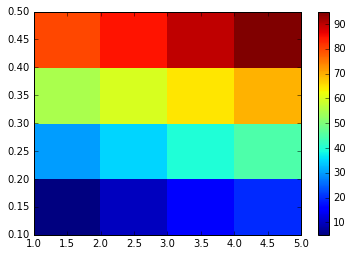

In [53]:
import matplotlib.pyplot as plt
import numpy as np

#here's our data to plot, all normal Python lists
x = [1, 2, 3, 4, 5]
y = [0.1, 0.2, 0.3, 0.4, 0.5]

intensity = [
    [5, 10, 15, 20, 25],
    [30, 35, 40, 45, 50],
    [55, 60, 65, 70, 75],
    [80, 85, 90, 95, 100],
    [105, 110, 115, 120, 125]
]

#setup the 2D grid with Numpy
x, y = np.meshgrid(x, y)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(intensity)

#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale
plt.show() #boom

In [56]:
type(df.age)

pandas.core.series.Series

In [111]:
len(newdf['supergroups_enc'].unique())

66

In [118]:
newdf.groupby('eco_enc')['eco_enc'].count().max()

37693

In [60]:
import seaborn as sns

In [83]:
eco_result_df['eco_enc'] = pd.Categorical(eco_result_df['eco']).codes

In [84]:
eco_result_df

,eco,result,eco_enc
0,B59,-0.264113,159
1,C38,-0.235294,238
2,C20,-0.203774,220
3,A76,-0.160000,76
4,E03,-0.146667,403
5,B73,-0.138254,173
6,B25,-0.136935,125
7,D04,-0.136610,304
8,B26,-0.126839,126
9,C56,-0.121911,256


In [94]:
testgrid = np.meshgrid(eco_result_df.eco_enc, eco_result_df.eco_enc)

In [119]:
x,y = np.meshgrid(eco_result_df.eco_enc, eco_result_df.eco_enc)

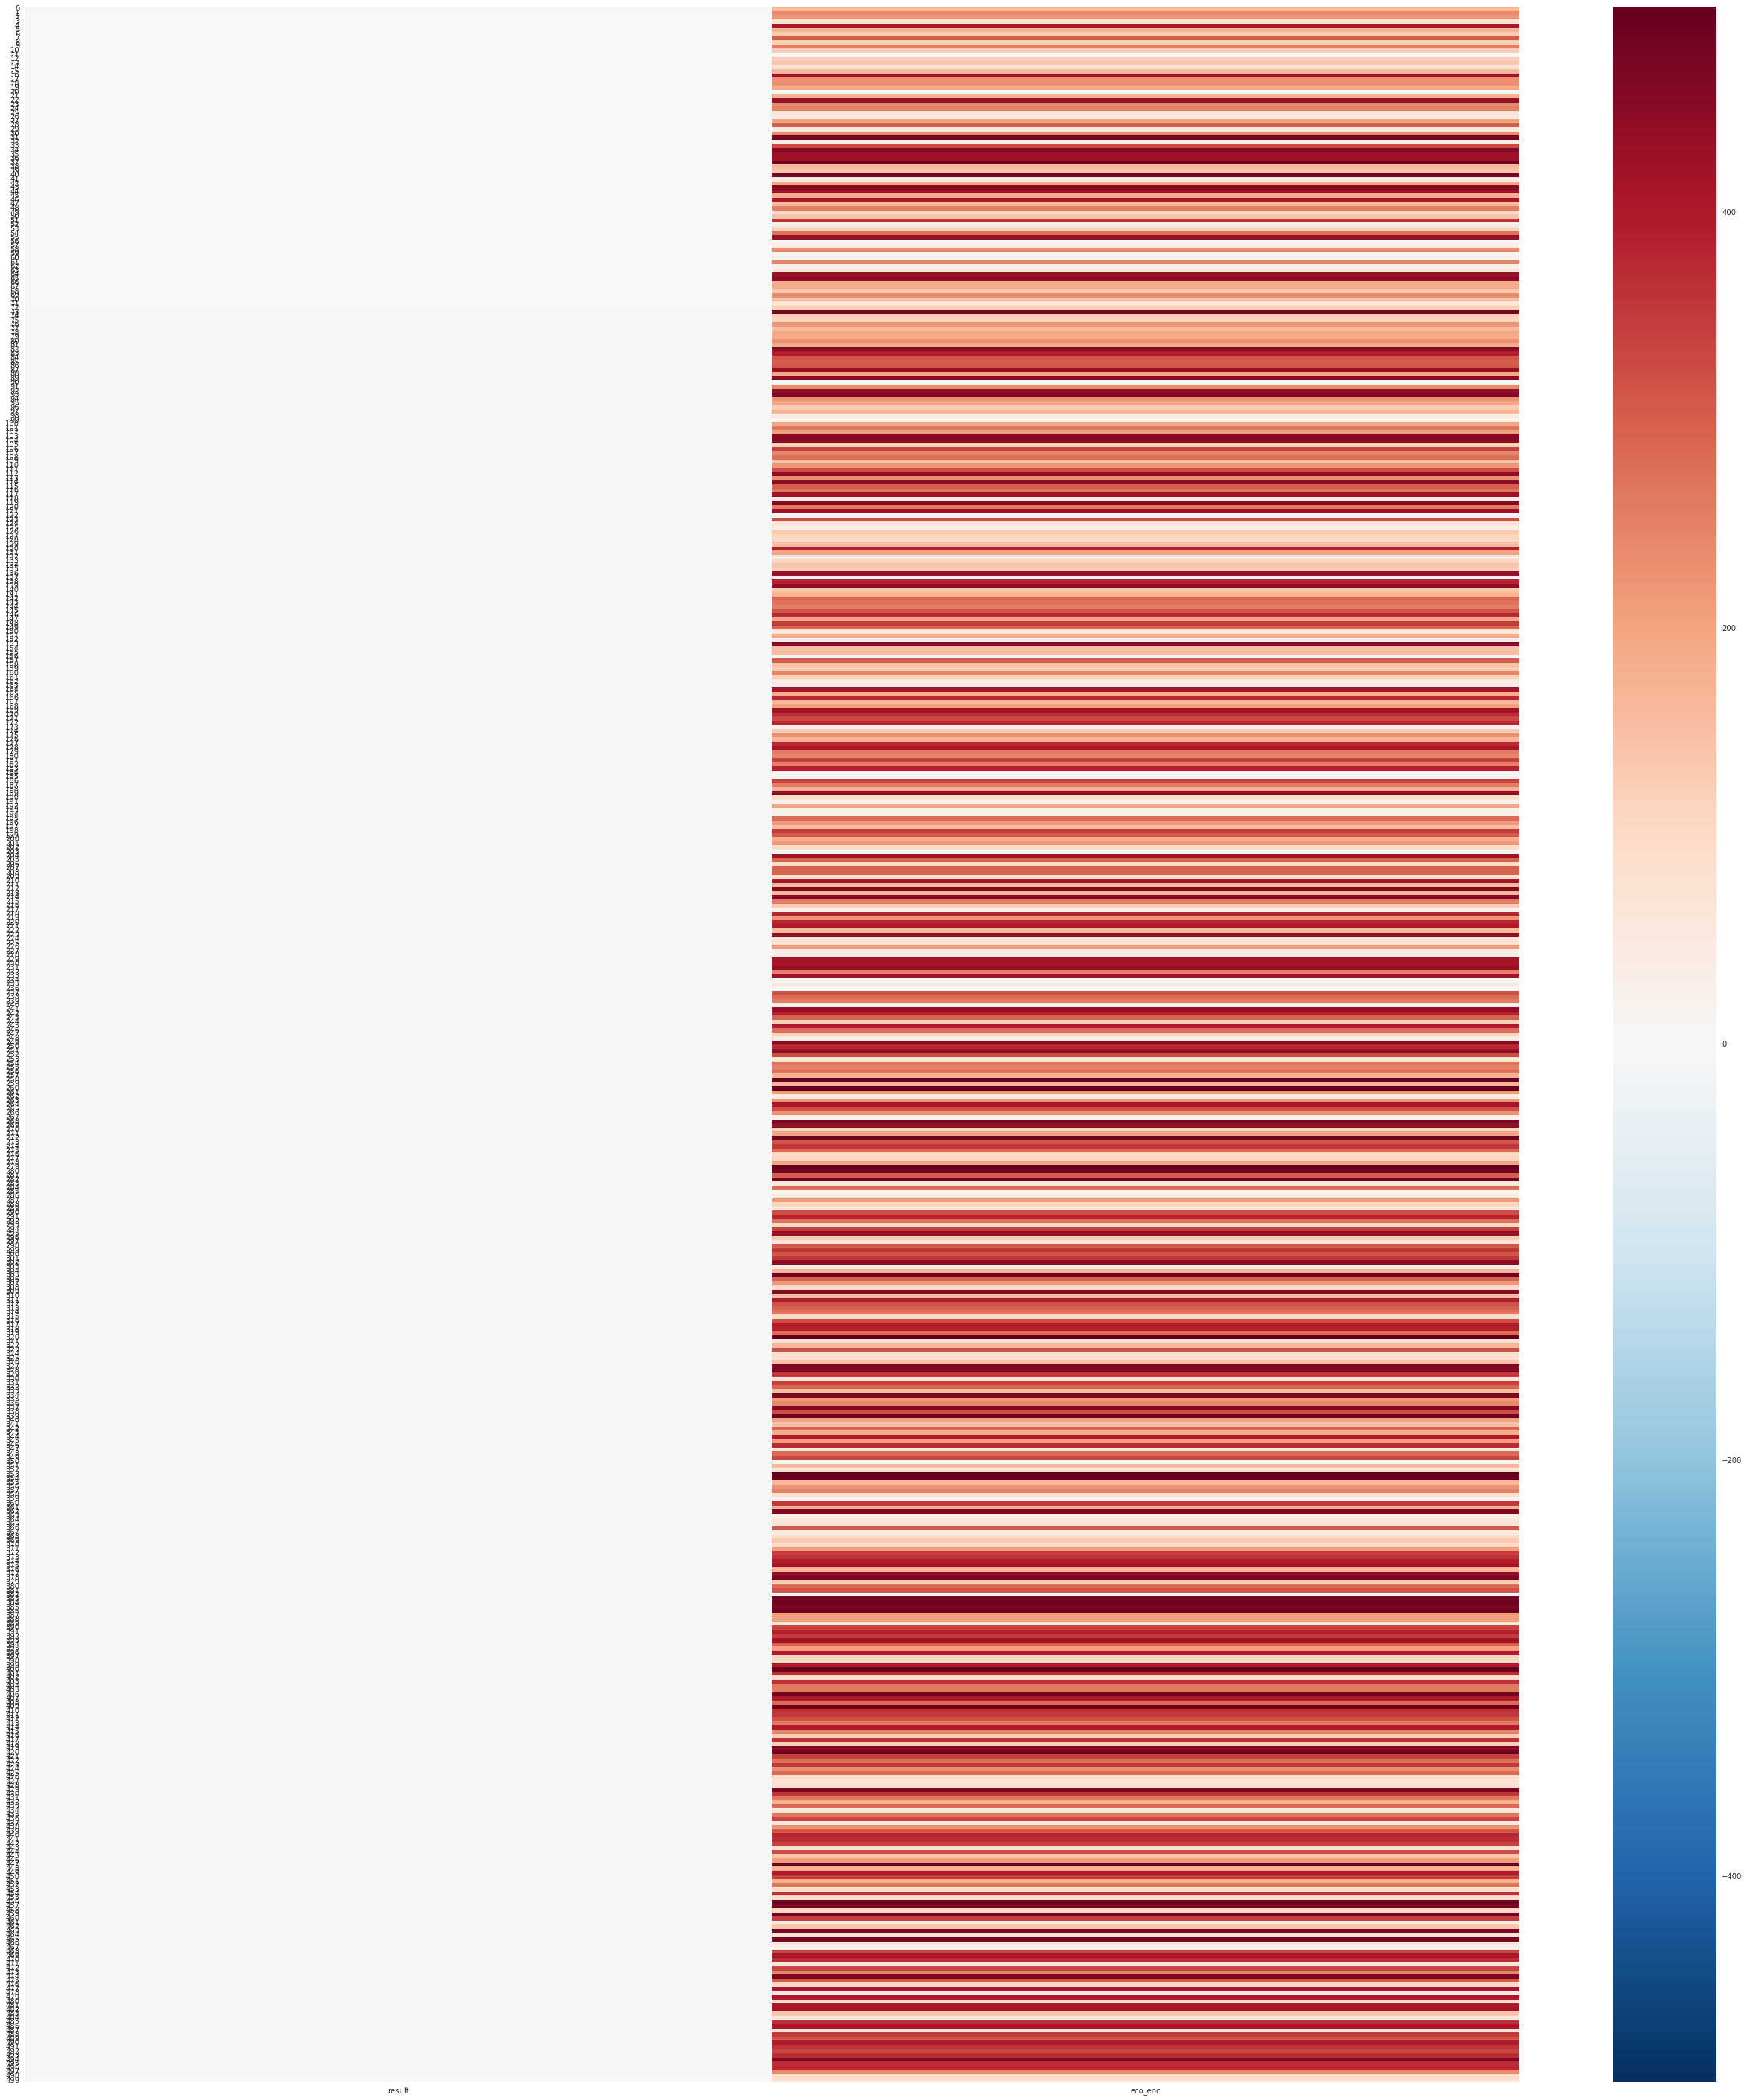

In [98]:

import matplotlib as mpl 
mpl.rc("figure", figsize=(45, 50))
sns.heatmap(eco_result_df[['result','eco_enc']])

In [122]:
#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(eco_result_df.result)



In [ ]:
#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale
plt.show() #boom

In [99]:
#sns.heatmap(testgrid)

creating a spare matrix as input for training will save time.  Will consider adding this for white/black names

In [126]:
from pandas.core.categorical import Categorical
from scipy.sparse import csr_matrix
import numpy as np

def sparse_dummies(categorical_values):
    categories = Categorical.from_array(categorical_values)
    N = len(categorical_values)
    row_numbers = np.arange(N, dtype=np.int)
    ones = np.ones((N,))
    return csr_matrix( (ones, (row_numbers, categories.codes)) )


In [128]:
white_cat = sparse_dummies(newdf.white_enc)
black_cat = sparse_dummies(newdf.black_enc)

In [132]:
from scipy.sparse import hstack
hstack((white_cat,black_cat), format="csr")

<1791126x115981 sparse matrix of type '<type 'numpy.float64'>'
	with 3582252 stored elements in Compressed Sparse Row format>

In [133]:
sparse_dummies(newdf.white_enc)

<1791126x57767 sparse matrix of type '<type 'numpy.float64'>'
	with 1791126 stored elements in Compressed Sparse Row format>

In [ ]:
#     plt.figure()
#     plt.pcolor(dataframe)
#     plt.colorbar()
#     plt.savefig("myheatmap.png")
#     plt.close()

In [ ]:
# some basic stats about opening popularity

In [137]:
wfm_pop = newdf.groupby('white_first_move')['white_enc'].count().reset_index()

In [139]:
wfm_pop = wfm_pop.sort('white_enc')

/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [192]:
wfm_pop.head()

,white_first_move,white_enc
14,1.f3,9
5,1.a4,11
0,1.Na3,12
19,1.h4,29
3,1.Nh3,35


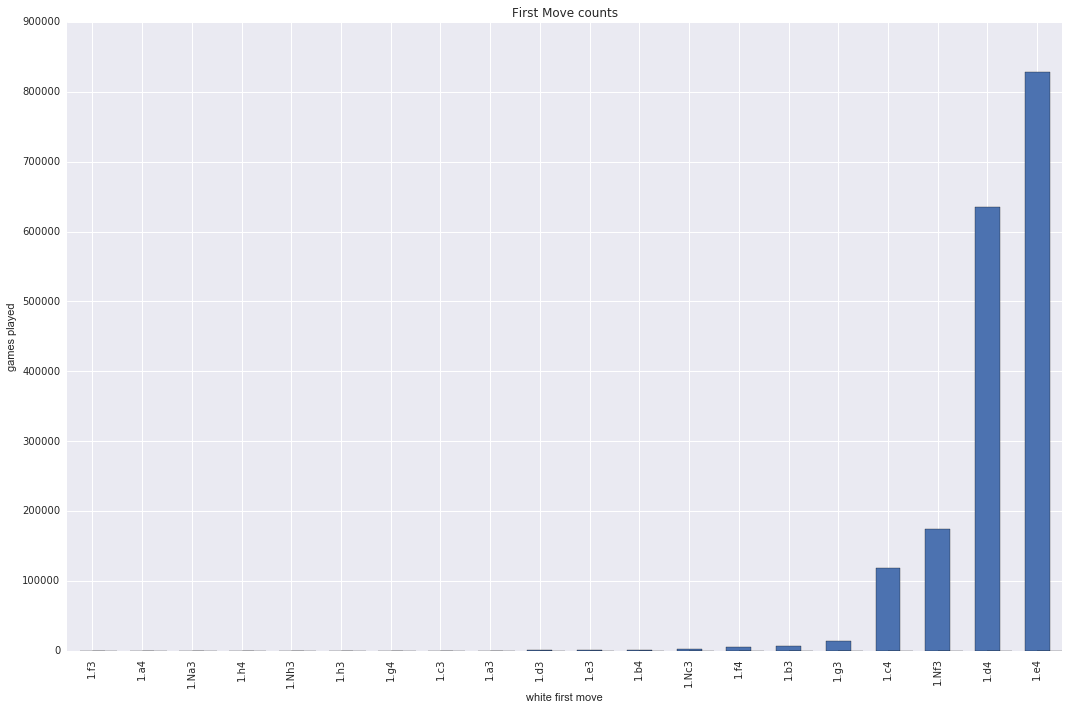

In [219]:
import matplotlib as mpl 
mpl.rc("figure", figsize=(15,10))
import pylab as plt
LABELS = wfm_pop.white_first_move.tolist()
#plt.bar(wfm_pop.white_first_move,wfm_pop.white_enc,LABELS)

ax = wfm_pop[['white_first_move','white_enc']].plot(x='white_first_move',y='white_enc',kind='bar',title='First Move counts',legend=False,)
ax.set_xlabel("white first move")
ax.set_ylabel("games played")
# N = 20
# ind = np.arange(N)
# vals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# colors = ['r','b','b','b','b','r','b','b','b','b','r','b','b','b','b','r','b','b','b','b']
# ax.bar(ind,vals,0.5,color=colors)
# plt.tight_layout()


In [368]:
sg_pop =df.groupby('supergroups').count().reset_index()

In [394]:
sg_pop.head(1)

,supergroups,black,blackelo,eco,moves,result,white,whiteelo,white_first_move,black_first_move,...,wfm_count,p_wfm,bfm_count,p_bfm,wfm_success,bfm_result_sum,bfm_success,groups,sgmoves,list_groups
26,C20 King's pawn game,265,265,265,265,265,265,265,265,265,...,265,265,265,265,265,265,265,265,265,265


/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


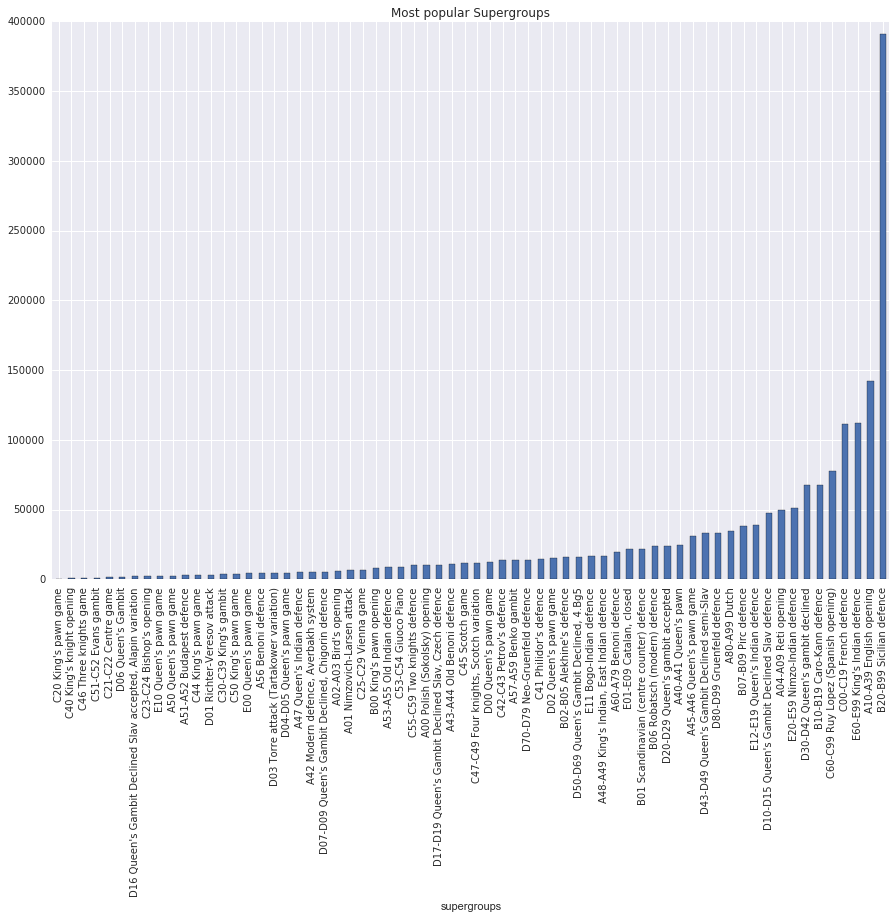

In [378]:
sg_pop = sg_pop.sort('black')
sg_pop[['supergroups','black']].plot(x='supergroups',y='black',kind='bar',legend=False,title='Most popular Supergroups')


/Users/eduardodaroza/anaconda2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


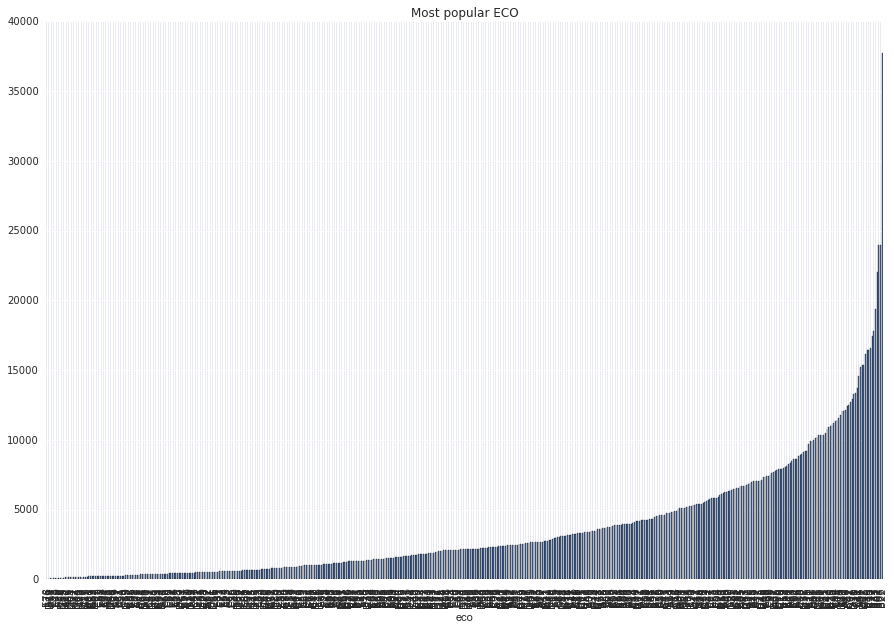

In [379]:
eco_pop =df.groupby('eco').count().reset_index()
eco_pop = eco_pop.sort('black')
eco_pop[['eco','black']].plot(x='eco',y='black',kind='bar',legend=False,title='Most popular ECO')


In [383]:
eco_pop.tail()  #Sicilian, Alapin is most popular ECO

,eco,black,blackelo,moves,result,white,whiteelo,white_first_move,black_first_move,age,...,p_wfm,bfm_count,p_bfm,wfm_success,bfm_result_sum,bfm_success,groups,supergroups,sgmoves,list_groups
133,B33,19354,19354,19354,19354,19354,19354,19354,19354,19354,...,19354,19354,19354,19354,19354,19354,19354,19354,19354,19354
101,B01,22053,22053,22053,22053,22053,22053,22053,22053,22053,...,22053,22053,22053,22053,22053,22053,22053,22053,22053,22053
107,B07,23943,23943,23943,23943,23943,23943,23943,23943,23943,...,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943
106,B06,23977,23977,23977,23977,23977,23977,23977,23977,23977,...,23977,23977,23977,23977,23977,23977,23977,23977,23977,23977
122,B22,37693,37693,37693,37693,37693,37693,37693,37693,37693,...,37693,37693,37693,37693,37693,37693,37693,37693,37693,37693


In [177]:
temp = newdf.groupby('white_enc')['white_first_move_enc'].unique().reset_index()

In [229]:
df.groupby('white').count().black.mean() #avg number of games per player

31.00604151158966

In [309]:
df.groupby('black').count().white.mean()

30.767959597347716

In [238]:
test2 = df.groupby(['white','white_first_move']).count().reset_index()

In [393]:
test2.groupby('white').count().mean().head(1)  #mean openings...most players play 2 first moves, max was 16

white_first_move    1.915644
dtype: float64

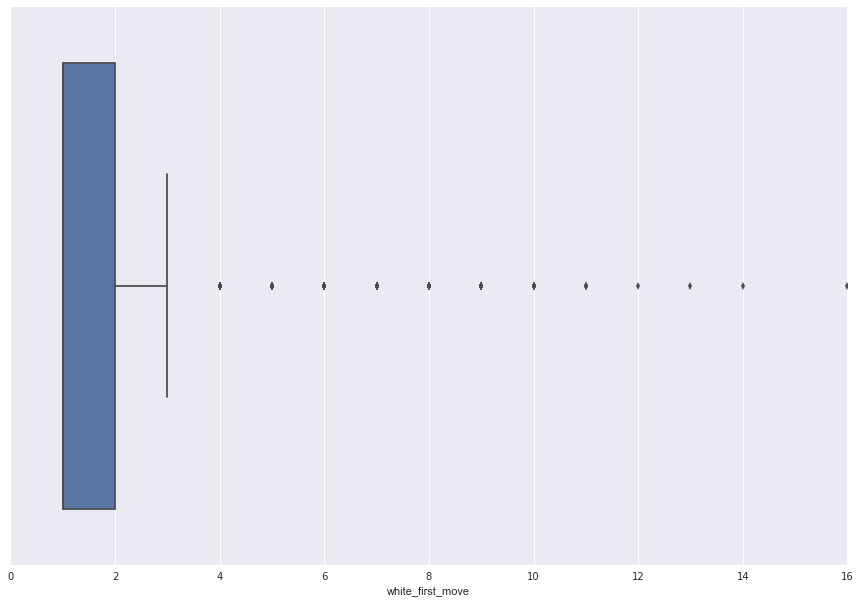

In [332]:
sns.boxplot(test2.groupby('white').count().reset_index()['white_first_move']) # most player centered at 2

In [311]:
test3 = df.groupby(['white','eco']).count().reset_index()

In [312]:
test3.head(1)

,white,eco,black,blackelo,moves,result,whiteelo,white_first_move,black_first_move,age,...,p_wfm,bfm_count,p_bfm,wfm_success,bfm_result_sum,bfm_success,groups,supergroups,sgmoves,list_groups
0,"Aaberg, Anton",A04,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


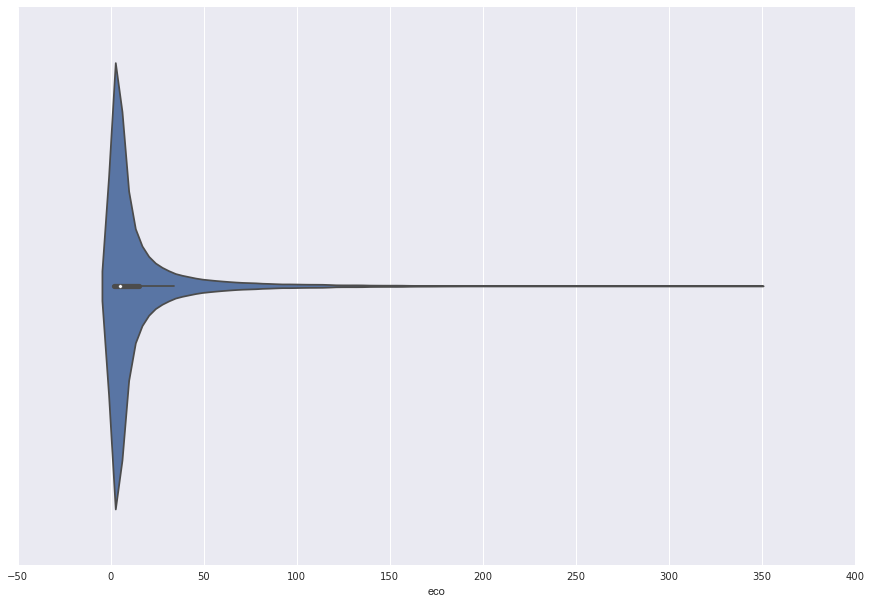

In [329]:
#sns.boxplot(test3.groupby('white').count().reset_index()['eco'])
sns.violinplot(test3.groupby('white').count().reset_index()['eco']) #violinplot showing distribution opening//player
#test3.groupby('white').count().reset_index()['eco'].max()

In [392]:
test3.groupby('white').count().mean().head(1)  #mean openings for white...most players play up to 16 different ECO codes

eco    15.137241
dtype: float64

In [247]:
test4 = df.groupby(['white','supergroups']).count().reset_index()

In [391]:
test4.groupby('white').count().mean().head(1) #7 supergroups mean

supergroups    7.309814
dtype: float64

In [390]:
df[df['black'] =='Carlsen, Magnus']['black_enc'].head(1)

5602    739
Name: black_enc, dtype: int64

In [333]:
#df.info()


In [353]:
import cPickle as pickle
df = pickle.load( open( "../data/df_final_master3.pkl", "rb" ) )

In [346]:
magdf = df[df.white=='Carlsen, Magnus']

In [387]:
magdf.white_enc.head(1)

487    754
Name: white_enc, dtype: int64

In [386]:
magdf[magdf.black=='Karjakin, Sergey'].black_enc.head(1)

70420    996
Name: black_enc, dtype: int64

In [351]:
kardf = df[df.white=='Karjakin, Sergey']

In [388]:
kardf.white_enc.head(1)

365    607
Name: white_enc, dtype: int64

In [389]:
df[df.white=='Kosteniuk, Alexandra'].white_enc.head(1)


71243    2784
Name: white_enc, dtype: int64

In [359]:
#magdf = df[df.white=='Carlsen, Magnus']
#magdf.white_enc.head()
#magdf[magdf.black=='Karjakin, Sergey'].black_enc.head()
#kardf = df[df.white=='Karjakin, Sergey']
#kardf.white_enc.head()
kardf[kardf.black=='Carlsen, Magnus'].black_enc.head()

215644    739
216115    739
216507    739
241946    739
242477    739
Name: black_enc, dtype: int64

In [ ]:
754 996
607 739

In [439]:
import re
from collections import defaultdict
target_dict = defaultdict(dict)
count = 0
d = dict()
with open('misc/pgn/eco.pgn','r') as f:
    #read_data = f.readline()
    for line in f:
        if line.startswith("1. "):
            line = re.sub(r"\d+\.", "", line).strip()
            #check to see if a root is created.  If not add.
            #print line
            line_arr = line.split()
            for la in line_arr:
                if target_dict['name'] == la:
                target_dict['name']['child'] = la
            print target_dict
#                 for element in line:
#                     d["name"] = element
#                 print line
    #lines = [line.rstrip('\n') for line in f]
    #print read_data
    #if read_data.startswith("1."):

    count += count
f.closed
print count

defaultdict(<type 'dict'>, {'name': {'child': 'b4'}})
defaultdict(<type 'dict'>, {'name': {'child': 'Nh6'}})
defaultdict(<type 'dict'>, {'name': {'child': 'c6'}})
defaultdict(<type 'dict'>, {'name': {'child': 'g3'}})
defaultdict(<type 'dict'>, {'name': {'child': 'h5'}})
defaultdict(<type 'dict'>, {'name': {'child': 'Nf3'}})
defaultdict(<type 'dict'>, {'name': {'child': 'g4'}})
defaultdict(<type 'dict'>, {'name': {'child': 'g5'}})
defaultdict(<type 'dict'>, {'name': {'child': 'c4'}})
defaultdict(<type 'dict'>, {'name': {'child': 'd4'}})
defaultdict(<type 'dict'>, {'name': {'child': 'h3'}})
defaultdict(<type 'dict'>, {'name': {'child': 'a3'}})
defaultdict(<type 'dict'>, {'name': {'child': 'Nh3'}})
defaultdict(<type 'dict'>, {'name': {'child': 'exf4'}})
defaultdict(<type 'dict'>, {'name': {'child': 'Nc3'}})
defaultdict(<type 'dict'>, {'name': {'child': 'e5'}})
defaultdict(<type 'dict'>, {'name': {'child': 'a3'}})
defaultdict(<type 'dict'>, {'name': {'child': 'Qh4'}})
defaultdict(<type 'di

In [436]:
import collections
d = collections.defaultdict(dict)
d['name'] = 'value'
d['child'] = 'nextvalue'

In [ ]:
import pandas as pd
import json

def find_element(children_list,name):
    """
    Find element in children list
    if exists or return none
    """
    for i in children_list:
        if i["name"] == name:
            return i
    #If not found return None
    return None

def add_node(path,value,nest):
    """
    The path is a list.  Each element is a name that corresponds 
    to a level in the final nested dictionary.  
    """

    #Get first name from path
    this_name = path.pop(0)

    #Does the element exist already?
    element = find_element(nest["children"], this_name)

    #If the element exists, we can use it, otherwise we need to create a new one
    if element:

        if len(path)>0:
            add_node(path,value, element)

    #Else it does not exist so create it and return its children
    else:

        if len(path) == 0:
            nest["children"].append({"name": this_name, "value": value})
        else:
            #Add new element
            nest["children"].append({"name": this_name, "children":[]})

            #Get added element 
            element = nest["children"][-1]

            #Still elements of path left so recurse
            add_node(path,value, element)

In [414]:
topo = {
  'm0' : {
    'm1' : {},
    'm2' : {},
    'm3' : {},
  },
}

In [418]:
def compact_to_verbose(compact):
    return [{'name':key, 'children':compact_to_verbose(value)} for key, value in compact]
def verbose_to_compact(verbose):
    return { item['name']: verbose_to_compact(item['children']) for item in verbose }

In [420]:
compact_to_verbose(topo)[0]

ValueError: need more than 1 value to unpack